### Imports

In [1]:
import importlib
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import modules.data_processing
from scipy.stats import ttest_ind, chi2_contingency, percentileofscore

In [225]:
## NLP imports

from textblob import TextBlob
import spacy
import string
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from wikitextparser import remove_markup, parse
from collections import defaultdict
from wordcloud import WordCloud
from nltk import ngrams
from nltk.util import ngrams
import networkx as nx

In [3]:
importlib.reload(modules.data_processing)
from modules.data_processing import *

In [4]:
DATA_PATH = './data/wiki-RfA.txt'
EDITORS_PATH = './data/top_editors.txt'
AUTHORS_PATH = './data/top_authors.txt'
CREATORS_PATH = './data/top_creators.txt'

### Extracting Dataset

We start by defining a function that parses the data file and creates a pandas DataFrame containing the parsed data.

In [5]:
wiki_df = extract_data(DATA_PATH)

In [6]:
wiki_df.head(5)

,SRC,TGT,VOT,RES,YEA,DAT,TXT
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit..."


### Data Processing

Before we start processing data, we need to look at what our parsed dataset looks like in order to use the correct types and to fix any noticebly inconsistent values.

In [7]:
wiki_df.shape

(198275, 7)

In [8]:
wiki_df.columns.values

array(['SRC', 'TGT', 'VOT', 'RES', 'YEA', 'DAT', 'TXT'], dtype=object)

Let's check if there are any columns with NULL or empty values.

In [9]:
null_columns = wiki_df.columns[wiki_df.isnull().any()]
empty_string_columns = wiki_df.columns[(wiki_df == '').any()]



print("Columns containing NULL values:")
print(null_columns)

print("\nColumns containing empty strings:")
print(empty_string_columns)



Columns containing NULL values:
Index([], dtype='object')

Columns containing empty strings:
Index(['SRC', 'DAT', 'TXT'], dtype='object')


We notice there are occurences where the DAT, SRC or TXT is empty.

For DAT and SRC, we replace the empty values by np.nan so we can easility process them later on. <br>
However, the empty TXT values will be treated later when processing the text data.

In [10]:
wiki_df['DAT'].replace('', np.nan, inplace=True)
wiki_df['SRC'].replace('', np.nan, inplace=True)

Now, let us appropriately format the data in the different columns.

In [11]:
wiki_df[['VOT', 'RES', 'YEA']] = wiki_df[['VOT', 'RES', 'YEA']].apply(lambda x: pd.to_numeric(x, errors='coerce'))

# We map RES values to (0, 1) to make them easy to process
wiki_df['RES'] = wiki_df['RES'].apply(lambda x: 1 if x == 1 else 0 )

#### DAT

We format the DAT column, and check which rows have not been correctly formatted.

In [12]:
inconsistent_dates = pd.to_datetime(wiki_df['DAT'], format='mixed', errors='coerce').isna() & (~wiki_df['DAT'].isna())

wiki_df[inconsistent_dates]

,SRC,TGT,VOT,RES,YEA,DAT,TXT
6821,JonasEncyclopedia,Zagalejo,1,1,2012,"14:47, 1 Julu 2012",'''Support'''. A versatile editor and active c...
27608,HJ Mitchell,Alan16,0,0,2010,"20:44, 3 Janry 2010",'''Neutral'''. Answers to the questions aren't...
70591,Pathoschild,Werdna,1,1,2008,"31:29, 24 May 2008",Support because Shanel told me too. <small>(Gi...
116963,QuasyBoy,Imdanumber1,1,0,2007,"17:44, 26 Mya 2007",'''Support''' You've been doing a great job wi...


We will fix these inconsistent date values one by one.

In [13]:
wiki_df['DAT'] = pd.to_datetime(wiki_df['DAT'], format='mixed', errors='coerce')
wiki_df.at[6821, 'DAT'] = pd.to_datetime('2012-07-01 14:47')
wiki_df.at[27608, 'DAT'] = pd.to_datetime('2010-01-03 20:44')
wiki_df.at[116963, 'DAT'] = pd.to_datetime('2007-05-26 14:47')

In [14]:
wiki_df[inconsistent_dates]

,SRC,TGT,VOT,RES,YEA,DAT,TXT
6821,JonasEncyclopedia,Zagalejo,1,1,2012,2012-07-01 14:47:00,'''Support'''. A versatile editor and active c...
27608,HJ Mitchell,Alan16,0,0,2010,2010-01-03 20:44:00,'''Neutral'''. Answers to the questions aren't...
70591,Pathoschild,Werdna,1,1,2008,NaT,Support because Shanel told me too. <small>(Gi...
116963,QuasyBoy,Imdanumber1,1,0,2007,2007-05-26 14:47:00,'''Support''' You've been doing a great job wi...


The only remaining issue is with the row n° 70591, the date shows "31:29" which is an invalid hour, in order to fix this issue, we need to look at neighboring votes, as they're sorted mainly chronologically, to infer the correct value.

In [15]:
wiki_df.loc[70589:70593]

,SRC,TGT,VOT,RES,YEA,DAT,TXT
70589,Bhadani,Werdna,1,1,2008,2008-05-24 03:13:00,'''Support''': --
70590,Shanel,Werdna,1,1,2008,2008-05-24 03:18:00,'''Support'''. I have known Werdna for about 1...
70591,Pathoschild,Werdna,1,1,2008,NaT,Support because Shanel told me too. <small>(Gi...
70592,Swatjester,Werdna,1,1,2008,2008-05-24 03:37:00,'''Support''' per lolcat.
70593,KnowledgeOfSelf,Werdna,1,1,2008,2008-05-24 04:37:00,'''Support''' Yes please.


Looking at this, it seems that "31:29" most likely was supposed to be "03:29", we will manually fix this error.

In [16]:
wiki_df.at[70591, 'DAT'] = pd.to_datetime('2008-05-24 03:29')

Finally :

In [17]:
wiki_df[inconsistent_dates]

,SRC,TGT,VOT,RES,YEA,DAT,TXT
6821,JonasEncyclopedia,Zagalejo,1,1,2012,2012-07-01 14:47:00,'''Support'''. A versatile editor and active c...
27608,HJ Mitchell,Alan16,0,0,2010,2010-01-03 20:44:00,'''Neutral'''. Answers to the questions aren't...
70591,Pathoschild,Werdna,1,1,2008,2008-05-24 03:29:00,Support because Shanel told me too. <small>(Gi...
116963,QuasyBoy,Imdanumber1,1,0,2007,2007-05-26 14:47:00,'''Support''' You've been doing a great job wi...


#### SRC

The first problem is finding the reason why the is missing in this column. If we can answer this question, we'll be able to process the data more effectively and thus avoid encountering problems later on when analysing the data.

In [18]:
empty_or_null_src = wiki_df[pd.isna(wiki_df['SRC'])]
non_empty_or_null_src = wiki_df[~pd.isna(wiki_df['SRC'])]
display(empty_or_null_src)

,SRC,TGT,VOT,RES,YEA,DAT,TXT
707,NaN,Jason Quinn,0,1,2013,NaT,
708,NaN,Jason Quinn,0,1,2013,NaT,
793,NaN,Legoktm,1,1,2013,NaT,
1126,NaN,Mattythewhite,-1,1,2013,NaT,
1128,NaN,Mattythewhite,-1,1,2013,NaT,
...,...,...,...,...,...,...,...
198052,NaN,Yelyos,1,0,2004,NaT,
198116,NaN,Christopher Mahan,1,1,2003,NaT,
198171,NaN,Jwrosenzweig,1,1,2003,NaT,
198217,NaN,Patrick,1,1,2003,NaT,


In [19]:
print(f'Number of missing data for SRC column: {len(empty_or_null_src)}')

Number of missing data for SRC column: 1661


We notice that for rows where the SRC value is missing, the TXT value seems to also be missing, let's see if this is the case for all the rows.

In [20]:
empty_or_null_src_txt = empty_or_null_src[pd.isna(empty_or_null_src['TXT']) | (empty_or_null_src['TXT'] == '')]
print(f'Number of missing data for TXT column when SRC is missing: {len(empty_or_null_src_txt)}')

Number of missing data for TXT column when SRC is missing: 1661


We thus find that all the rows where the SRC value is missing, also have the TXT value as missing. Let's now see if the same holds for the DAT value.

In [21]:
empty_or_null_src_dat = empty_or_null_src[pd.isna(empty_or_null_src['DAT'])]
print(f'Number of missing data for DAT column when SRC is missing: {len(empty_or_null_src_dat)}')

Number of missing data for DAT column when SRC is missing: 1661


Thus, whenever the SRC value is missing, the DAT and TXT values are also missing. <br>
The first hypothesis is that it might because of an error in the parsing of the file, however, a manual verification in the raw data file leads to the conclusion that those missing values are not a result of a parsing error.

Let us explore this missing data to see if we can extract any information from it.

First thing we will do is plot the indexes of the missing data, as this can inform us on when missing data happens and whether it has something to do with the ordering in the file.

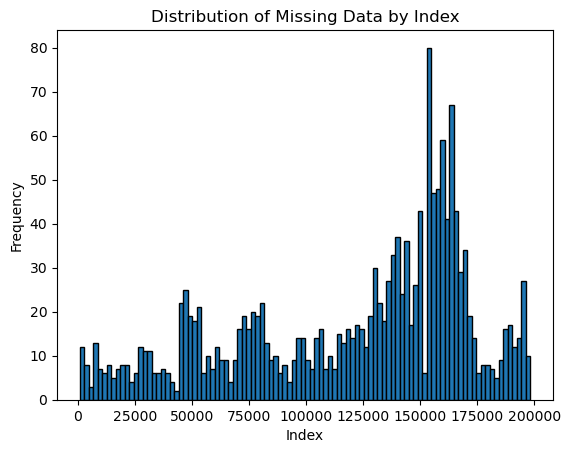

In [22]:
indexes = empty_or_null_src.index

plt.hist(indexes, bins=100, edgecolor='k')
plt.xlabel('Index')
plt.ylabel('Frequency')
plt.title('Distribution of Missing Data by Index')
plt.show()

We can see there is a higher concentration of missing data towards the end of the file, between index 150 000 and index 170 000, signaling there might be a problem with the data in that region of the file. However, we cannot draw conclusions as it can be that missing data is more frequent for a certain year, and that that year is located in that region of the file, for instance.

Which is why we also need to plot the distribution of the missing data throughout the years.

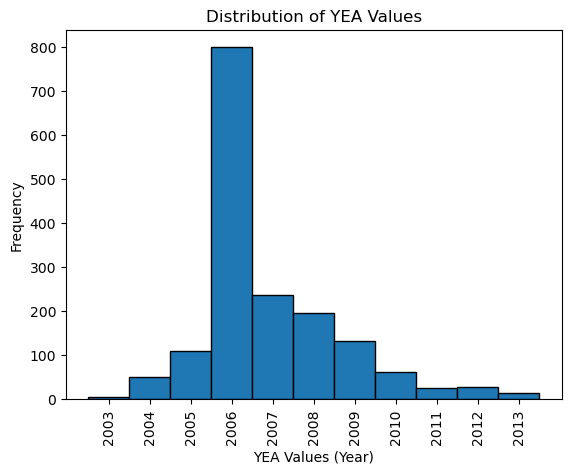

In [23]:
yea_values = empty_or_null_src['YEA']
min_year = min(yea_values)
max_year = max(yea_values)
year_range = max_year - min_year + 1 

plt.hist(yea_values, bins=year_range, range=(min_year - 0.5, max_year + 0.5), edgecolor='k')
plt.xticks(range(min_year, max_year + 1), rotation=90)

plt.xlabel('YEA Values (Year)')
plt.ylabel('Frequency')
plt.title('Distribution of YEA Values')
plt.show()

We can see that the year 2006 has more missing values, however, this could simply be because that year has more data, and thus also more missing data. We need to check the percentage of missing data by year.

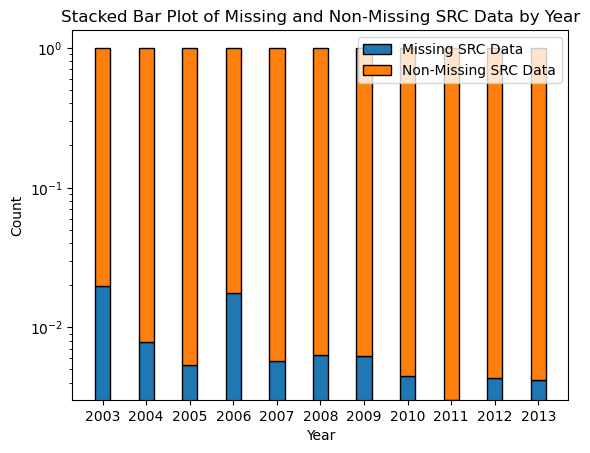

In [24]:
# We get the total number of available (missing or not) data for each year
yearly_data_counts = wiki_df['YEA'].value_counts().sort_index()

# We calculate the percentages of missing data and non missing data.
missing_src_percentages = empty_or_null_src['YEA'].value_counts().sort_index() / yearly_data_counts
non_missing_src_percentages = non_empty_or_null_src['YEA'].value_counts().sort_index() / yearly_data_counts

# We create a stacked bar plot
fig, ax = plt.subplots()
bar_width = 0.35
years = yearly_data_counts.index


plt.bar(years, missing_src_percentages, bar_width, label='Missing SRC Data', edgecolor='k')
plt.bar(years, non_missing_src_percentages, bar_width, label='Non-Missing SRC Data', edgecolor='k', bottom=missing_src_percentages)

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Stacked Bar Plot of Missing and Non-Missing SRC Data by Year')
plt.xticks(years)
plt.yscale('log')
plt.legend()
plt.show()

We see that indeed there is more missing data for the years 2003 and 2006. Now, back to our initial hypothesis, which is that some part of the file might be corrupted, could it be, that for those years, a big part lies between the indexes where most of the missing data happens?

In [25]:
wiki_df.iloc[150000:170000]['YEA'].unique()

array([2006], dtype=int64)

We notice, that in those indexes, there is only votes corresponding to the year 2006, which might explain the number of missing data.

In all cases, the fact that missing data happens in all years, seems to suggest that it isn't an error of parsing but simply a reality that comes with our dataset.

Now, what do we do with this missing data?


First let's take a look at the amount of missing data

In [26]:
missing_src_percentages * 100

YEA
2003    1.970443
2004    0.779697
2005    0.538564
2006    1.765030
2007    0.570521
2008    0.639785
2009    0.622222
2010    0.450966
2011    0.303880
2012    0.432499
2013    0.419933
Name: count, dtype: float64

We have less than 1% of missing data for all the years except for the years 2003 and 2006 where we have less than 2%.

It appears that the missing data in this dataset may signify instances where users' accounts were potentially deleted or encountered other similar issues. While retaining their votes to justify election outcomes, the remaining data could have been discarded for GDPR compliance. An exploration could investigate whether this absence of data influences election results by comparing elections with and without missing data. Such analysis might reveal any discrepancies in the displayed results in the 'RES' column. 

Because of this, we have decided to keep those votes when analysing the data.

##### Grouping Elections 

In order to analyse the elections' data, we need to draw a line between different elections. Fortunately, it seems that in our data file, the votes are ordered by election and by time, meaning, when a candidate changes in the data, that means that the vote is for a new election.

We use that information to identify different elections.

In [27]:
wiki_df['ELECTION_ID'] = 0
current_id = 1

for index, row in wiki_df.iterrows():
    tgt_value = row['TGT']
    
    if index > 0 and wiki_df.at[index - 1, 'TGT'] != tgt_value:
        current_id += 1  # Increment ELECTION_ID for a new 'TGT' value
    
    wiki_df.at[index, 'ELECTION_ID'] = current_id

In [28]:
display(wiki_df)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,1
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,1
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,1
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1
...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,2003-09-02 02:51:00,Support,3926
198271,Angela,WhisperToMe,1,1,2003,2003-11-26 23:45:00,Support.,3927
198272,Jiang,WhisperToMe,1,1,2003,NaT,Support. --,3927
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05 05:38:00,Support. Age has nothing to do with maturity....,3927


We have given consecutive rows with the same "TGT" value the same ELECTION_ID value, however, we have not yet verified if there are instances where non-consecutive rows with the same "TGT" value belong to the same election.<br> To identify this, we will group by ELECTION_ID values and look at groups that have less than 5 voters, as this might signify that there is a problem with the grouping, we will then analyze some of these occurences to see if we can draw any conclusions from them.

In [29]:
grouped_elections = wiki_df.groupby('ELECTION_ID').size()
grouped_elections[grouped_elections <= 5]

ELECTION_ID
70      3
71      5
117     2
125     4
127     3
       ..
3924    5
3925    3
3926    3
3927    3
3928    1
Length: 335, dtype: int64

Let's take the election with id 70 and see why it has so little voters. We will look at the rows with that Election_ID, and then we will look at all rows with that election 'TGT' to see if we are missing some votes.

In [30]:
wiki_df[wiki_df['ELECTION_ID'] == 70]

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
7329,Cyberpower678,Baseballrocks538,-1,0,2012,2012-03-06 23:15:00,'''Strongest Oppose''' This user clearly does ...,70
7330,Eagles247,Baseballrocks538,-1,0,2012,2012-03-06 23:16:00,'''Oppose''' per warnings on user's talk page....,70
7331,SarekOfVulcan,Baseballrocks538,-1,0,2012,2012-03-06 23:17:00,"Sorry, but [[WP:NOTYET]]. You need a lot more ...",70


In [31]:
wiki_df[wiki_df['TGT'] == 'Baseballrocks538']

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
7329,Cyberpower678,Baseballrocks538,-1,0,2012,2012-03-06 23:15:00,'''Strongest Oppose''' This user clearly does ...,70
7330,Eagles247,Baseballrocks538,-1,0,2012,2012-03-06 23:16:00,'''Oppose''' per warnings on user's talk page....,70
7331,SarekOfVulcan,Baseballrocks538,-1,0,2012,2012-03-06 23:17:00,"Sorry, but [[WP:NOTYET]]. You need a lot more ...",70


As we can see, it seems that the "Baseballrocks538" has indeed only received three votes, and that it doesn't come from a problem in our grouping.

Let's take an occurence where a same TGT corresponds to more than one ELECTION_ID, and analyse the different election groups.

In [32]:
unique_election_id_counts = wiki_df.groupby('TGT')['ELECTION_ID'].nunique()
unique_election_id_counts[unique_election_id_counts > 2]

TGT
Carnildo             3
Cobi                 3
Cool3                3
Curtis23             3
Elonka               3
Enigmaman            3
Everyking            6
Firefoxman           3
Footballfan190       3
Geni                 3
Guanaco              4
HJ Mitchell          3
Hex                  3
Ironholds            4
Juliancolton         3
Ktr101               4
Kww                  3
Leonard^Bloom        3
MONGO                3
MZMcBride            4
MoRsE                3
Porchcrop            3
Richardcavell        3
Robchurch            3
ST47                 3
Sceptre              3
Shoessss             3
Slon02               3
TenPoundHammer       3
The Transhumanist    4
Thumperward          3
Werdna               3
Wikiwoohoo           4
ZooPro               3
^demon               3
Name: ELECTION_ID, dtype: int64

Let's take the user 'Carnildo' for instance and look at the different election groups to which he belongs.

In [33]:
carnildo_df = wiki_df[(wiki_df['TGT'] == 'Carnildo')]
carnildo_df['ELECTION_ID'].unique()

array([2239, 2608, 3064], dtype=int64)

In [34]:
carnildo_df[carnildo_df['ELECTION_ID'] == 2239].head(5)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
129888,UninvitedCompany,Carnildo,1,1,2006,2006-08-18 22:48:00,,2239
129889,Chacor,Carnildo,1,1,2006,2006-08-29 03:05:00,"This is bound to be a controversial RFA, but e...",2239
129890,crazytales56297,Carnildo,1,1,2006,2006-08-29 03:07:00,'''Support''' per Chacor. <!--begin crazytales...,2239
129891,Sean Black,Carnildo,1,1,2006,2006-08-29 03:09:00,--[[Special:Contributions/Sean Black|SB]] |,2239
129892,Mindspillage,Carnildo,1,1,2006,2006-08-29 03:20:00,'''Support'''. I believe the incident for whic...,2239


In [35]:
carnildo_df[carnildo_df['ELECTION_ID'] == 2608].head(5)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
155749,Jahiegel,Carnildo,1,0,2006,2006-03-20 21:36:00,I've been waiting for Carnildo to accept and a...,2608
155750,RN,Carnildo,1,0,2006,2006-03-20 22:06:00,[[Image:Symbol support vote.svg|15px]] '''Supp...,2608
155751,BD2412,Carnildo,1,0,2006,2006-03-20 22:11:00,"''NEVER!!!'' Oh, wait, this is ''[[User:Carnil...",2608
155752,Rune.welsh,Carnildo,1,0,2006,2006-03-20 22:28:00,'''Strong support'''. His work regarding image...,2608
155753,Alhutch,Carnildo,1,0,2006,2006-03-20 22:43:00,'''Support''' per Rune. good user.--,2608


In [36]:
carnildo_df[carnildo_df['ELECTION_ID'] == 3064].head(5)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
173443,Redwolf24,Carnildo,1,1,2005,2005-08-13 01:34:00,"<font size=""+2"">SUPPORT!</font>",3064
173444,Starblind,Carnildo,1,1,2005,NaT,"'''Strong Support''' Excellent editor, strong ...",3064
173445,RN,Carnildo,1,1,2005,2005-08-13 03:57:00,'''Strong Support''' He can be a bit confrenta...,3064
173446,Denelson83,Carnildo,1,1,2005,2005-08-13 06:06:00,"'''Support!''' Support! Support! <span style=""...",3064
173447,Merovingian,Carnildo,1,1,2005,NaT,,3064


As we can see, the different ELECTION_ID correspond indeed to different elections.

We can also notice that a candidate can run for elections multiple times, even in the same year, which is why it is important to group elections in the order they appear in rather than taking the "YEA" column value for instance. Moreover, we notice that a candidate can run another time, even after winning an election, which is an odd occurence as adminship is supposed to be a definitive status, so how can it be that someone can run for adminship again, even after supposedly being elected the first time?

Let's see how many times that occur. We first group by elections, and then group by candidate, summing the results of the election. If the value is greater than 1, than means the candidate has won more than 1 election.

In [37]:
grouped_elections = wiki_df[['ELECTION_ID', 'RES', 'TGT']].drop_duplicates()
won_elections = grouped_elections.groupby('TGT')['RES'].sum()

In [38]:
print(f'Number of candidates having won more than one election: {len(won_elections[won_elections > 1])}\n')
display(won_elections[won_elections > 1])

Number of candidates having won more than one election: 18



TGT
Carnildo           2
Croat Canuck       2
Danny              2
Evercat            2
Everyking          2
Geni               2
Guanaco            2
HJ Mitchell        2
MZMcBride          2
Nev1               2
PMelvilleAustin    2
PeterSymonds       2
SarekOfVulcan      2
Sarge Baldy        2
Sean Black         2
Ugen64             2
W.marsh            2
^demon             2
Name: RES, dtype: int64

As we can see, there are 18 candidates who have one more than one election (precisely, two elections).

A quick look at Carnildo's history, shows us that he has been 'resysopped', meaning reelected (cf: https://en.wikipedia.org/wiki/Wikipedia:Wikipedia_Signpost/2006-09-11/Carnildo_resysopped), which explains the fact that he has won two elections.

In fact, we find out that all the candidates in the list were reelected as well, as their names can be found in Wikipedia's list of resysopped users: https://en.wikipedia.org/wiki/Wikipedia:List_of_resysopped_users.

#### Text Processing

### Text preprocessing

In [39]:
len(wiki_df[wiki_df['TXT'] == '']['TXT'])

7190

* We notice that we have 7190 missing values among comments. 

We don't do the replacement at this stage of empty comments by NaN, because we intend to maintain them as strings for the following steps. 

#### Removing the Wiki Markup from the comments

In [40]:
# Make sure that TXT is string
wiki_df['TXT'] = wiki_df['TXT'].astype(str)

* We will try to use a python library called "wikitextparser" to easily remove the wiki markup. 

In [41]:
# comment example from the dataset 
example = wiki_df.iloc[66609]['TXT']
example

"Congratulatory '''Support''' - Excellent [[Wikipedia:WikiProject Military history|WikiProject:Military history]] experience with this user. Can be trusted with new responsibility."

In [42]:
remove_markup(example)

'Congratulatory Support - Excellent WikiProject:Military history experience with this user. Can be trusted with new responsibility.'

* The library didn't handle the link removal as expected. Therefore, we will implement a classic function using regular expressions to remove the wiki markup, relying on the Wikitext structure on the website [Wikitext](https://en.wikipedia.org/wiki/Help:Wikitext).

In [43]:
remove_wiki_markup(example)

'Congratulatory Support - Excellent  experience with this user. Can be trusted with new responsibility.'

* The results is indeed what we want. Let's test on a random sample of comments.

In [44]:
txts = wiki_df['TXT'].sample(10).copy()
for i, comment in enumerate(txts): 
    print(i, ' : ' , comment)
    print() 

0  :  '''Moral support''' Longtime user with a clean blocklog and varied contributions. SoWhy's examples are troubling, However  I'm not opposing because they aren't in the area that you intend to work in per q1. Hope to see you here again in three months or so, but please be a little more cautious at new page patrol - remember if in doubt categorise! ''

1  :  '''Support'''. A quality candidate here my friends. &mdash;

2  :  '''Oppose''' per issues stated above.--

3  :  '''Support''' seems a capable user will make a good admin. --

4  :  '''Oppose''' per many reasons above, and the candidate has very little experience in many areas of the project. ---

5  :  '''Support''' Good, responsible contributor.

6  :  '''Oppose''' - Just not comfortable going for support. Also with regards to the Arbcom issue. (I have read many of the links on this page.) I am not fearful that Geni would intentionally abuse the tools. I do not fear that he would become a dictator. I do, however, fear, that h

In [45]:
for i, comment in enumerate(txts): 
    print(i, ' : ' , remove_wiki_markup(comment))
    print() 

0  :  Moral support Longtime user with a clean blocklog and varied contributions. SoWhy's examples are troubling, However  I'm not opposing because they aren't in the area that you intend to work in per q1. Hope to see you here again in three months or so, but please be a little more cautious at new page patrol - remember if in doubt categorise! ''

1  :  Support. A quality candidate here my friends. 

2  :  Oppose per issues stated above. 

3  :  Support seems a capable user will make a good admin.  

4  :  Oppose per many reasons above, and the candidate has very little experience in many areas of the project.  -

5  :  Support Good, responsible contributor.

6  :  Oppose - Just not comfortable going for support. Also with regards to the Arbcom issue. (I have read many of the links on this page.) I am not fearful that Geni would intentionally abuse the tools. I do not fear that he would become a dictator. I do, however, fear, that he would have a lack of neutrality in resolving confl

* It seems that it works well on the comments of our dataset. We create then a column for cleaned comments.

In [46]:
wiki_df['CLE'] = wiki_df['TXT'].apply(remove_wiki_markup)
wiki_df.head()

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,1,Support as co-nom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,1,Support as nominator.
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,1,Support per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,Support per noms. BDD is a strong contributor ...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,"Support, with great pleasure. I work with BDD ..."


In [47]:
comments_with_one_char = wiki_df.loc[(wiki_df['CLE'].apply(len) == 1)]['CLE'].unique() # one char in the comments
comments_with_one_char

array([' ', '—', '-', '+', '→', "'", '.', '}', '!', '–', 'S', '·', 'I',
       '~', '«', '↔', 'C', ':', '(', '"', '/'], dtype=object)

In [48]:
comments_with_two_char = wiki_df.loc[(wiki_df['CLE'].apply(len) == 2)]['CLE'].unique() # two char in the comments
comments_with_two_char

array(['  ', '- ', ' /', '— ', '+ ', '←.', ' [', '. ', "''", ' (', '⇦⇨',
       ' —', 'OK', '}—', ' -', "':", '我是', '++', 'CO', '~ ', ' ~', ' C',
       'Q8', ' ☺', 'No', ' 〈', 'Da', 'S.', '! ', ':)'], dtype=object)

* We will delete those comments containing one or two characters that are meaningless for our study.

In [49]:
wiki_df['CLE'] = wiki_df['CLE'].apply(lambda x: '' if len(x) < 3 and x not in ['OK', 'No']  else x)
wiki_df.loc[(wiki_df['CLE'].apply(len) < 3)]['CLE'].unique()

array(['', 'OK', 'No'], dtype=object)

In [50]:
wiki_df.loc[(wiki_df['CLE'].apply(len) == 3)]['CLE'].unique()

array(['←  ', '!!!', '   ', ' - ', 'Ja.', 'OK.', "I'm", 'Yes', '.  ',
       " ''", '+1–', '賛成 ', ' ••', '} —', '他是好', 'wow', '  ~', "'' ",
       ' ~~', 'No ', '^.^', 'S+1', "''÷", 'yup', ' – ', '➲  ', 'Yay',
       '  |', 'Q3.', '  (', 'yes', '-  ', 'Yup', '➔  ', 'Aye', '➨  ',
       'Q1.', '9 (', '...', 'No.', 'Yep', ' — ', '— (', '— [', '. —',
       "—''", ' :)', ' (/', ' (|', 'yep', '}} ', 'Baa', 'Moo', 'Ok.',
       '!  ', "— '", '. -', ':) ', 's  ', ". '", ' ;)', 'Yo.', ' ()',
       ' ("', ':-)', 'NO.'], dtype=object)

In [51]:
wiki_df.loc[(wiki_df['CLE'].apply(len) == 4)]['CLE'].unique()

array(['. - ', 'Yay.', 'Q2 -', 'Sure', 'Yup.', 'Wow.', '.   ', " - '",
       'Yes.', " I'm", 'Duh.', 'Oui ', 'I  /', 'Yeps', '  — ', 'Yes!',
       'Yep.', '. ? ', 'Oui.', 'jo  ', '+1  ', 'Yes ', 'Yep!', ' .  ',
       'See ', '. ~~', 'NEWT', '  (|', '. – ', ' . —', 'AGF ', 'FGJ–',
       'yup.', 'Yep ', '➨ ❝❞', 'Duh!', '-   ', '   ·', 'DUH!', 'Aye.',
       'Meh.', ". ''", "! ''", 'Nom.', '  . ', ' ...', '. — ', "Q5 '",
       'okay', 'Aww.', 'Yup ', 'I am', 'Yea.', ',   ', 'Pig.', '  (/',
       'Yo. ', 'Mop.', 'Wow!', '100%', 'Yes,', "I'm ", 'No. ', 'Bleh',
       '   (', 'Да! ', 'Yay!', '.  |', ' ( -', '«»(|', ', . ', 'TAK!',
       '<3  ', 'yes!', 'Moo.', 'Cool', 'Hai ', 'Pro.', 'Sup ', 'YES!',
       'Ja! ', ' ort', 'yep.', 'Who?', 'Yup,', 'No  ', 'Heh.'],
      dtype=object)

In [52]:
wiki_df.loc[(wiki_df['CLE'].apply(len) == 5)]['CLE'].unique()

array(['100%.', 'Yo.  ', 'Yes! ', 'Q2. -', 'Aye.—', 'Sure.', 'nods ',
       'Meh -', 'Yerp.', 'Uhhhh', 'Per .', 'Sold.', 'Duh →', 'Sure ',
       'sure ', 'Yes  ', 'Solid', "Yep '", 'AGF  ', '.    ', 'Okay.',
       'Fine.', '    ·', 'Yup. ', 'Yes. ', 'Yup  ', 'No.  ', 'Yes —',
       'Damn,', 'Nom  ', 'Desu.', 'Yep. ', '.   (', 'Aye. ', 'Ok. —',
       '+S . ', '+S  (', ' () (', 'Aye  ', 'OK.  ', 'ok. —', '+1.  ',
       'Yup! ', 'Duh. ', 'PRO -', 'YES  ', '...  ', 'yes. ', 'Moo  ',
       'AGF. ', 'Oops.', 'Hut+!', 'See .', 'Yep  ', 'Yeap ', 'GL. –',
       ' ..  ', ' ⁿɡ͡b', 'Cool.', 'Fish.', "Sure'", 'Yes..', 'Yup..',
       'Oui!.', ". —''", 'Sure!', 'YEs. ', 'Yay. ', ".  ''", 'Duh .',
       'Gasp!', 'Mooo.', 'Agree', 'Yeah.', 'Sì.  ', 'TINC.', 'Frog.',
       'w00t.', 'SNFA.', 'Aye =', 'Duh  ', 'Okay!', 'Duh -', 'What?',
       'AOL!>', 'No ()', 'Ok.  ', 'Sí.  ', 'Mhmm.', 'Da.  ', '-"-  ',
       'No. -'], dtype=object)

When examining comments with a length greater than 2, we find various words and special characters that we cannot eliminate at this point. 
Due to the extensive number of words and special characters, exhaustive treatment of these comments (by studying the different combinaisons) becomes challenging. 

* Let's see then what are the words by which comments start.

In [53]:
cleaned_comments = wiki_df['CLE']

first_word_counts = defaultdict(int)
for comment in cleaned_comments: 
    if isinstance(comment, str) and comment.strip(): 
        first_word = comment.split()[0]
        first_word_counts[first_word] += 1
i = 0       
for word, count in first_word_counts.items(): 
    print(word, ', Occurrence :', count)
    if i == 15: 
        break
    i += 1

Support , Occurrence : 68955
Support, , Occurrence : 7585
Yea, , Occurrence : 6
Support. , Occurrence : 23921
If , Occurrence : 108
Weak , Occurrence : 3370
Support: , Occurrence : 1661
. , Occurrence : 165
Support...opposes , Occurrence : 1
Oppose. , Occurrence : 5538
Although , Occurrence : 68
Oppose , Occurrence : 21033
Fruitless , Occurrence : 3
Neutral , Occurrence : 5864
Yes , Occurrence : 153
Strong , Occurrence : 8394


In [54]:
# Some comments have become empty
# After the wiki markup removal
len(wiki_df[wiki_df['CLE'] == '']['CLE'])

9387

* In the cleaned comments, we have now 9387 missing values compared to the initial count of 7190. 

Let's take a look at the additional empty comments resulting from our processing.

In [55]:
wiki_df[(wiki_df['CLE'] == '') & (wiki_df['TXT'] != '') ]

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE
156,Rzuwig,Bilby,1,1,2013,2013-05-25 07:11:00,{{pro}} --,2,
276,Mabdul,Darkwind,1,1,2013,2012-12-26 20:39:00,"<small style=""font: 12px Courier New; color: #...",3,
300,Filelakeshoe,Darkwind,1,1,2013,2012-12-27 21:58:00,"<font face=""trebuchet MS"">- [[User:Filelakesho...",3,
427,LlamaAl,INeverCry,1,1,2013,2013-01-31 13:17:00,--,4,
441,Jan eissfeldt,INeverCry,1,1,2013,2013-01-31 20:03:00,--,4,
...,...,...,...,...,...,...,...,...,...
197931,Hcheney,Snowspinner,1,0,2004,2004-05-30 22:25:00,[[User:Hcheney/Support|Support]] --,3864,
197938,Anthony DiPierro,Snowspinner,1,0,2004,NaT,[[User:Hcheney/Support|Support]] [[User:Anthon...,3864,
197940,GeneralPatton,Snowspinner,1,0,2004,2004-06-02 18:13:00,--,3864,
197944,Texture,Snowspinner,1,0,2004,2004-06-04 14:30:00,[[User:Texture|<font color=red>T&#949;x</font>...,3864,


We can see that these comments initially contained only pure WikiMarkup and didn't contain any useful information for our analysis.

### Resulting Dataframes 

Now that we have processed the data, we will create new dataframes containing statistics about the individuals and the elections that can be directly used when working with the data.

Let's start with the elections, we group the same elections and, as we did earlier, get the :
- Candidate
- Year
- Number of positive, neutral and negative votes.
- Percentage of positive, neutral and negative votes.
- Total number of votes
- Earliest and latest voting date.

For this, we define a function that directly does the grouping and the aggregation.

In [56]:
elections_df = create_elections_df(wiki_df)

In [57]:
elections_df.head(5)

,ELECTION_ID,TGT,RES,Total Votes,Positive Votes,Negative Votes,Neutral Votes,Positive Percentage,Negative Percentage,Neutral Percentage,Earliest Voting Date,Latest Voting Date
0,1,BDD,1,137,119,14,4,86.861314,10.218978,2.919708,2013-04-19 23:13:00,2013-04-26 22:12:00
1,2,Bilby,1,137,134,2,1,97.810219,1.459854,0.729927,2013-05-25 00:37:00,2013-06-01 13:13:00
2,3,Darkwind,1,146,108,30,8,73.972603,20.547945,5.479452,2012-12-26 20:12:00,2013-01-02 21:23:00
3,4,INeverCry,1,110,101,8,1,91.818182,7.272727,0.909091,2013-01-31 08:17:00,2013-02-07 02:27:00
4,5,Jason Quinn,1,183,138,29,16,75.409836,15.846995,8.743169,2013-01-25 03:30:00,2013-02-01 00:08:00


Now, we create a dataframe that contains the following information about candidates:
- The number of times they run for an election
- The number of times they won
- The number of times they lost
- The number of votes they received
- The percentage of positive votes they received
- The percentage of negative votes they received
- The percentage of neutral votes they received
- The average length of the comments they received

In [58]:
candidates_df = create_candidates_df(wiki_df)

In [59]:
candidates_df.head(10)

,USER,Number of Elections,Won Elections,Lost Elections,Votes Received,Positive Percentage,Negative Percentage,Neutral Percentage,Average Length Received
0,(aeropagitica),1,1,0,55,0.727273,0.181818,0.090909,106.672727
1,07bargem,1,0,1,6,0.000000,1.000000,0.000000,278.500000
2,1234r00t,1,0,1,6,0.000000,1.000000,0.000000,275.333333
3,168...,1,1,0,7,1.000000,0.000000,0.000000,42.000000
4,21655,1,0,1,24,0.166667,0.750000,0.083333,324.833333
5,23skidoo,1,1,0,58,1.000000,0.000000,0.000000,50.637931
6,28bytes,2,1,1,188,0.840426,0.132979,0.026596,217.938859
7,2over0,1,1,0,94,1.000000,0.000000,0.000000,106.765957
8,4836.03,1,0,1,26,0.076923,0.769231,0.153846,123.153846
9,5 albert square,1,1,0,104,0.971154,0.019231,0.009615,141.538462


Now, we create a dataframe that contains the following information about candidates:
- The years they were active in
- The number of votes they cast
- The percentage of positive votes they cast
- The percentage of negative votes they cast
- The percentage of neutral votes they cast
- The percentage of times they voted similarly to the election result
- The percentage of times they voted differently than the election result
- The average length of the comments they cast

In [60]:
voters_df = create_voters_df(wiki_df)

In [61]:
voters_df.head(10)

,USER,Active Years,Votes Count,Positive Percentage,Negative Percentage,Neutral Percentage,Voted Differently,Voted Similarly,Average Length Cast
0,!---slappdash---!,[2009],1,100.000000,0.000000,0.000000,0.000000,100.000000,105.000000
1,%D0%90,[2006],13,100.000000,0.000000,0.000000,15.384615,84.615385,60.692308
2,'sed,[2006],3,100.000000,0.000000,0.000000,66.666667,33.333333,90.666667
3,(.Y.),[2006],1,100.000000,0.000000,0.000000,0.000000,100.000000,58.000000
4,(:Julien:),[2005],1,100.000000,0.000000,0.000000,0.000000,100.000000,98.000000
5,(aeropagitica),"[2008, 2007, 2006]",442,57.692308,19.457014,22.850679,30.769231,69.230769,278.911765
6,*Kat*,"[2011, 2009, 2006]",5,80.000000,20.000000,0.000000,40.000000,60.000000,222.800000
7,*Spark*,[2006],1,100.000000,0.000000,0.000000,0.000000,100.000000,13.000000
8,*drew,"[2007, 2006, 2005]",29,75.862069,24.137931,0.000000,27.586207,72.413793,32.758621
9,-Midorihana-,"[2008, 2007]",75,84.000000,5.333333,10.666667,10.666667,89.333333,130.013333


### Additional Datasets

Since our goal is to analyse the reasons motivating people's votes, we need metrics to evaluate the productivity of users. For this reason, we use additional datasets that contain statistics about Wikipedia users, namely: the number of pages they created, the number of articles they wrote, and the number of edits they made.

Those datasets are taken from the following Wikipedia articles:

Number of pages created: https://en.wikipedia.org/wiki/User:Bryan/List_of_users_by_pages_created <br>
Number of articles: https://en.wikipedia.org/wiki/Wikipedia:List_of_Wikipedians_by_article_count <br>
Number of edits: https://en.wikipedia.org/wiki/Wikipedia:List_of_Wikipedians_by_number_of_edits <br>

The extracted data files are in the "data" folder, while the functions used to parse and format them are in the "data_processing" module.

In [62]:
editors_df = parse_other_datasets(EDITORS_PATH)
authors_df = parse_other_datasets(AUTHORS_PATH)
creators_df = parse_other_datasets(CREATORS_PATH)

format_editors_df(editors_df)
format_authors_df(authors_df)
format_creators_df(creators_df)

The edits' dataset contains additional information about the category of users the user belong to.

- AC	Account creator <br>
- Ad	Administrator <br>
- AP	Autopatrolled <br>
- B	Bureaucrat <br>
- Ch	CheckUser <br>
- Co	Confirmed <br>
- ECo	Extended confirmed <br>
- EFH	Edit filter helper <br>
- EFM	Edit filter manager <br>
- EM	Extended mover <br>
- EvCo	Event coordinator <br>
- F	File mover <br>
- IM	Import <br>
- IAd	Interface administrator <br>
- IP	IPblock-exempt <br>
- MM	Mass message senders <br>
- N	New page reviewer <br>
- O	Oversighter <br>
- Ro	Rollbacker <br>
- Rs	Researcher <br>
- Rv	Pending changes reviewer <br>
- TE	Template editor <br>

In [63]:
display(editors_df)

,RANK,USER,NB_EDITS,CAT
0,1,Ser Amantio di Nicolao,5705768,"AP, Ad"
1,2,BrownHairedGirl,2942733,"AP, ECo, EM, F, N, Rv, Ro, TE"
2,3,Jevansen,2408733,"AP, ECo, EM, Rv, Ro"
3,4,BD2412,2262281,"AP, IP, Ad"
4,5,Koavf,2153268,"AP, ECo, EM, F, N, Rv, Ro, TE"
...,...,...,...,...
9995,9996,Canis Lupus,11066,None
9996,9997,Shanel,11065,ECo
9997,9998,Cornellier,11064,"ECo, Rv"
9998,9999,Pink Fae,11064,"AP, ECo, Rv"


In [64]:
display(authors_df)

,RANK,USER,NB_ARTICLES
0,1,Yankees10,4821
1,1,Davidlofgren1996,4821
2,1,Kwamikagami,4821
3,1,Number 57,4821
4,1,Philafrenzy,4821
...,...,...,...
9996,9996,Kemkim,70
9997,9997,Karantsingh,70
9998,9998,Kaibabsquirrel,70
9999,9999,Jonyungk,70


In [65]:
display(creators_df)

,RANK,USER,NB_PAGES
0,1,Kotbot,55605
1,2,Dr. Blofeld,49089
2,3,Polbot,40174
3,4,Ram-Man,35076
4,5,AlbertHerring,14692
...,...,...,...
4995,4996,DavidCane,66
4996,4997,D Monack,66
4997,4998,Cwebb4,66
4998,4999,Colonies Chris,66


### Data Exploration

In this notebook, we analyse various variables influencing the acceptance or rejection of candidates in elections, aiming to uncover the factors leading to a successful outcome.

#### General Data Exploration

Let us look at the percentage of elections lost and won.

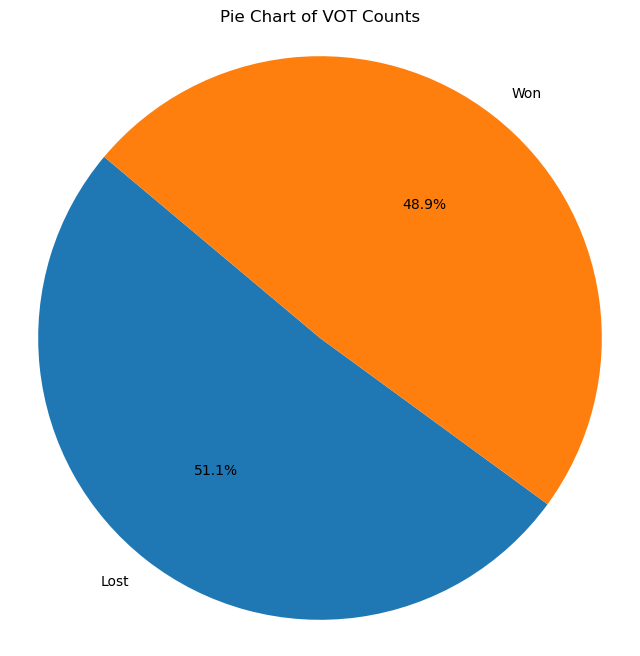

In [66]:
election_results_counts = elections_df['RES'].value_counts()

label_map = {1: 'Won', 0: 'Lost'}
election_labels = [label_map[val] for val in election_results_counts.index]

plt.figure(figsize=(8, 8))
plt.pie(election_results_counts, labels=election_labels, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of VOT Counts')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.show()

In [67]:
print(f'Total Number of Elections: {len(elections_df)}')

Total Number of Elections: 3928


We can see that we have 51% of elections lost, and 49% of elections won, and a total of 3928 elections.

We first start by doing a general data exploration to better understand the nature of our dataset and the conclusions we can draw from analysing it.

Let's take a look at the number of unique voters in the dataset.

In [68]:
print(f'Number of unique voters : {len(voters_df)}')

Number of unique voters : 10416


In [69]:
print(f'Number of unique members (either voters or candidates) : {len(pd.concat([voters_df["USER"], candidates_df["USER"]]).unique())}')

Number of unique members (either voters or candidates) : 11380


We can be more precise and look at the evolution of the number of voters per year. 

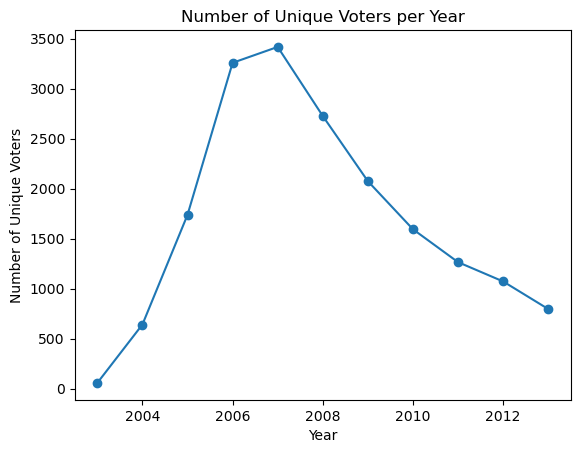

In [70]:
unique_voters_per_year = wiki_df.groupby(wiki_df['YEA'])['SRC'].nunique()

plt.plot(unique_voters_per_year.index, unique_voters_per_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Unique Voters')
plt.title('Number of Unique Voters per Year')
plt.show()

In [71]:
print(f'Average number of unique voters per year: {unique_voters_per_year.mean(): 0.0f}')

Average number of unique voters per year:  1694


We can see that the number of voters peaks for the years 2006 and 2007 and then slowly decreases again, with an average of 1694 voters per year.

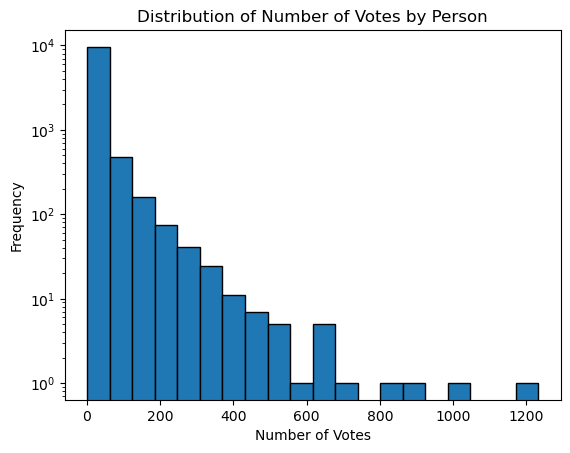

In [72]:
votes_distribution = voters_df['Votes Count']

plt.hist(votes_distribution, bins=20, edgecolor='k')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Distribution of Number of Votes by Person')
plt.show()

In [73]:
# Top voters
voters_df.nlargest(10, 'Votes Count')

,USER,Active Years,Votes Count,Positive Percentage,Negative Percentage,Neutral Percentage,Voted Differently,Voted Similarly,Average Length Cast
8222,Siva1979,"[2010, 2009, 2008, 2007, 2006]",1232,81.006494,14.285714,4.707792,39.285714,60.714286,149.906656
5571,Mailer diablo,"[2012, 2011, 2009, 2008, 2007, 2006, 2005]",998,79.659319,11.823647,8.517034,23.647295,76.352705,35.943888
5865,Merovingian,"[2009, 2008, 2007, 2006, 2005, 2004]",916,86.026201,5.895197,8.078603,22.707424,77.292576,21.573144
9874,Wizardman,"[2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006]",810,77.160494,18.148148,4.691358,38.888889,61.111111,104.849383
223,Acalamari,"[2013, 2012, 2011, 2010, 2009, 2008, 2007]",726,96.694215,2.341598,0.964187,27.134986,72.865014,183.603306
9968,Xoloz,"[2008, 2007, 2006, 2005]",677,46.085672,51.698671,2.215657,59.231905,40.768095,162.568685
6925,Pedro,"[2013, 2012, 2011, 2010, 2009, 2008, 2007]",663,69.834087,21.870287,8.295626,42.081448,57.918552,392.788839
2517,Dlohcierekim,"[2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006]",661,76.399395,17.700454,5.900151,41.754917,58.245083,233.453858
1003,Bearian,"[2013, 2012, 2011, 2010, 2009, 2008, 2007]",635,80.000000,8.188976,11.811024,27.086614,72.913386,156.757480
8571,Stifle,"[2013, 2011, 2010, 2009, 2008, 2007, 2006]",628,53.662420,32.484076,13.853503,49.203822,50.796178,83.853503


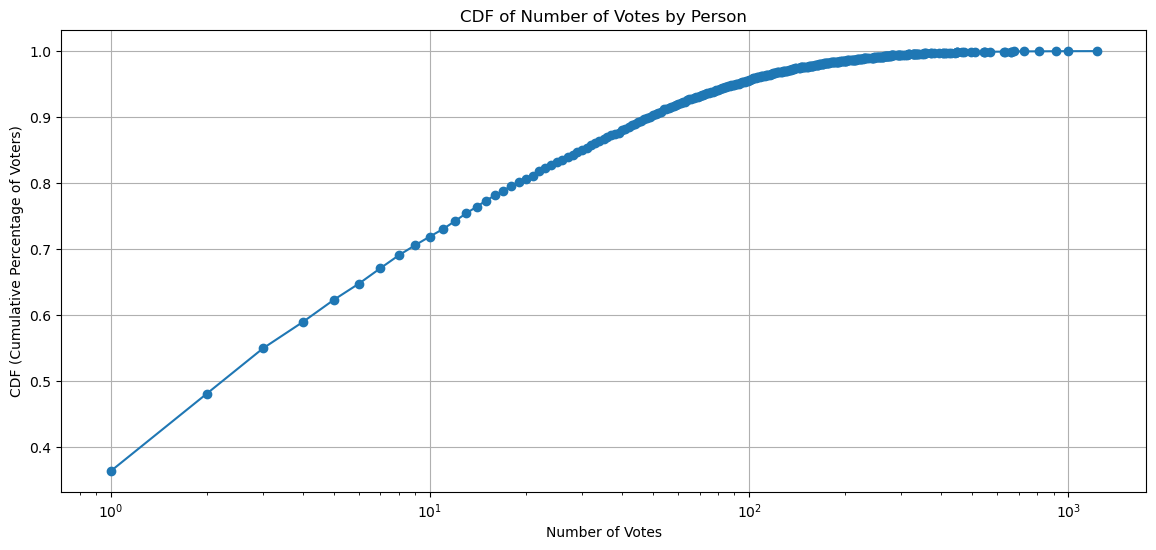

In [74]:
cdf = votes_distribution.value_counts().sort_index().cumsum() / len(votes_distribution) 

plt.figure(figsize=(14, 6))
plt.plot(cdf.index, cdf, marker='o', linestyle='-')
plt.xlabel('Number of Votes')
plt.ylabel('CDF (Cumulative Percentage of Voters)')
plt.title('CDF of Number of Votes by Person')
plt.xscale('log')
plt.grid(True)
plt.show()

In [75]:
print(f'Median of number of votes per voter: {votes_distribution.value_counts().sort_index().median()}')
print(f'Mean of number of votes per voter: {votes_distribution.value_counts().sort_index().mean()}')

Median of number of votes per voter: 3.0
Mean of number of votes per voter: 34.15081967213115


Looking at the CDF plot of the number of votes per person, we notice that half of the voters have voted less than 3 times, and 36% of the voters have only voted one time. <br>
The median of the number of votes per voter is 3 while the mean is 34, potentially signifying that our distribution is skewed to the right.

Let's analyse similarity of voters between each pair of years, this will allow us to see if the nature of voters change throughout the years.

In [76]:
voters_active_years = voters_df['Active Years']
unique_years = wiki_df['YEA'].unique()

results_df = pd.DataFrame(index=unique_years, columns=unique_years).astype(float)


In [77]:
# We go through pairs of years and extract the percentage of similar voters, we add them to a resulting dataframe
for y1 in unique_years:
    for y2 in unique_years:
        if y1 == y2:
            results_df.at[y1, y2] = 1
        else:
            results_df.at[y1, y2] = len(voters_active_years[voters_active_years.apply(lambda x: y1 in x and y2 in x)].index) / len(voters_active_years[voters_active_years.apply(lambda x: y1 in x)])


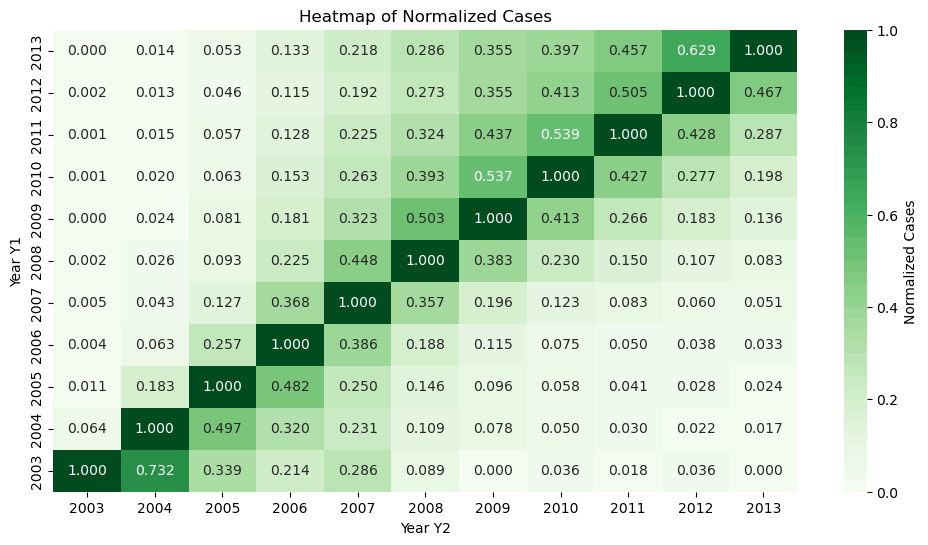

In [78]:
results_df = results_df.reindex(sorted(results_df.columns), axis=1)

plt.figure(figsize=(12, 6))
sns.heatmap(results_df, cmap=sns.color_palette("Greens", 40), annot=True, fmt=".3f", cbar_kws={'label': 'Normalized Cases'})

plt.xlabel('Year Y2')
plt.ylabel('Year Y1')
plt.title('Heatmap of Normalized Cases')

plt.show()

The heatmap reads like this : for a given pair of years ${y}_{i}, y_{j}$, the value in row $i$ and column $j$ is the percentage of voters in year $i$ that have also voted in year $j$.


The heatmap shows us that there is a lot of variability in the voters, and there aren't as many voters that are common between years as one would assume. However, this makes sense considering more than 50\% of voters have voted less than 4 times.

We can see higher values around the diagonal which shows the amount of common voters between close years, as the years drift apart, the number of common voters tend to reduce.

Such a vizualisation is important to see the correlation between the identities of voters between years. For instance, if we were ever to analyze text used in 2003 and compare it to the text used in 2013, we must be aware that there are no common voters between the two years, the analysis might thus reveal differences not because the language has changed, but rather because there are different voters using different language.

##### Candidates Exploration

We will now proceed with the same data exploration, but for candidates.

In [79]:
print(f'Number of unique candidates : {len(candidates_df["USER"])}')

Number of unique candidates : 3497


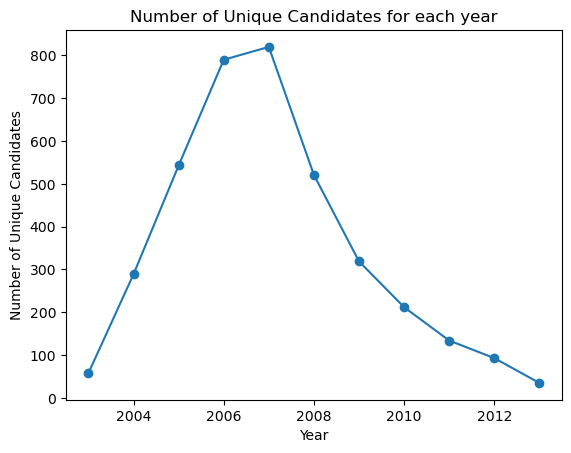

In [80]:
# Group by YEA and count the number of unique SRC
unique_candidates_per_year = wiki_df.groupby(wiki_df['YEA'])['TGT'].nunique()

plt.plot(unique_candidates_per_year.index, unique_candidates_per_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Unique Candidates')
plt.title('Number of Unique Candidates for each year')
plt.show()

##### Election Analysis

Now that we have successfully identified distinct elections, let's look at some statistics about the elections.

In [81]:
# Assuming 'total_votes', 'positive_percentage', and 'RES' are the columns in elections_df
plt.figure(figsize=(12, 8))

# Scatter plot with points colored by the percentage of positive votes
scatter = sns.scatterplot(x='total_votes', y='Positive Percentage', hue='RES', data=elections_df, palette={0: 'red', 1: 'green'}, s=15, alpha=0.6)

plt.axhspan(75, 105, color='green', alpha=0.2, label='Positive Votes > 75%')
plt.axhspan(-5, 75, color='red', alpha=0.2, label='Positive Votes <= 75%')

plt.title('Scatter Plot by Total Votes and Percentage of Positive Votes')
plt.xlabel('Number of Total Votes')
plt.ylabel('Percentage of Positive Votes')
plt.ylim(-5, 105)
plt.xscale('log')
plt.legend(title='Result of Election', loc='upper right', labels=['Not Elected', 'Elected'])

# Adjust the legend
handles, labels = scatter.get_legend_handles_labels()
labels[0] = 'Not Elected'
labels[1] = 'Elected'
scatter.legend(handles, labels, title='Result of Election', loc='lower right')

plt.show()

ValueError: Could not interpret value `total_votes` for parameter `x`

<Figure size 1200x800 with 0 Axes>

The wikipedia article about RfA elections states : "Consensus at RfA is not determined by surpassing a numerical threshold, but by the strength of rationales presented. In practice, most RfAs above 75% support pass." (https://en.wikipedia.org/wiki/Wikipedia:Requests_for_adminship).

The treshold is indeed noticeable, however, the plot shows that it is a bit below 75%. We can also notice that there are some exceptions that have a very high positive votes percentage, yet end up not being elected, and vice-versa. Which echoes the fact that a certain percentage of votes is not a guarantee of a successful election. However, the opposite seems to be true, indeed, for the vast majority of cases, it seems that having less than 50% of positive votes is a guarantee of failing the election.


But RfA is not a straightforward majority vote, there is no precise "pass" or "fail" percentage, the 75% is only given as an approximate guide and it is the job of bureaucrats to determine the concensus results of a request for admniship.


Indeed, there are even cases where candidates were rejected even if 100% of the votes they received were positives. Let's dig deeper into them.

In [82]:
elections_df[(elections_df['Positive Percentage'] == 100) & (elections_df['RES'] == 0)]

,ELECTION_ID,TGT,RES,Total Votes,Positive Votes,Negative Votes,Neutral Votes,Positive Percentage,Negative Percentage,Neutral Percentage,Earliest Voting Date,Latest Voting Date
1193,1194,matt037291,0,1,1,0,0,100.0,0.0,0.0,2008-12-22 11:06:00,2008-12-22 11:06:00
2003,2004,Moralis,0,1,1,0,0,100.0,0.0,0.0,2007-04-13 14:31:00,2007-04-13 14:31:00
2787,2788,LtPowers,0,1,1,0,0,100.0,0.0,0.0,2006-08-12 17:24:00,2006-08-12 17:24:00
2793,2794,madcowpoo,0,14,14,0,0,100.0,0.0,0.0,2006-10-02 19:42:00,2006-10-02 21:26:00
2950,2951,The Fish,0,13,13,0,0,100.0,0.0,0.0,2006-02-05 18:46:00,2006-02-08 23:27:00
2988,2989,Weyes3,0,1,1,0,0,100.0,0.0,0.0,2006-03-14 09:52:00,2006-03-14 09:52:00
3478,3479,Ilmari Karonen,0,1,1,0,0,100.0,0.0,0.0,2005-11-23 08:50:00,2005-11-23 08:50:00
3483,3484,"Just zis Guy, you know?",0,1,1,0,0,100.0,0.0,0.0,2005-11-05 10:14:00,2005-11-05 10:14:00
3494,3495,MarkGallagher,0,2,2,0,0,100.0,0.0,0.0,2005-10-28 15:48:00,2005-10-28 15:53:00
3526,3527,Robchurch,0,60,60,0,0,100.0,0.0,0.0,2005-10-10 00:21:00,2005-10-16 23:57:00


After conducting research on Wikipedia websites, specifically https://en.wikipedia.org/wiki/Wikipedia:Unsuccessful_adminship_candidacies/ + [first-letter-of-candidate], it becomes clear that, for the majority of these elections (with exceptions of `Moralis` and `Robchurch`), either the candidate refused the nomination, or the election was withdrawn by a bureaucrat who deemed the candidate unprepared. Thus, the margin remains at 1.0 due to the sudden end of the election but the recorded outcome is unsuccessful.

In the case of the candidate `Moralis`, the election followed a new experimental format of the RfA, which was not captured in this dataset.

The scenario involving the candidate `Robchurch` is particular. There were two distinct outcomes, initially negative and subsequently positive, for the same election. Unfortunately, the reasons for this dual outcome remain obscure.

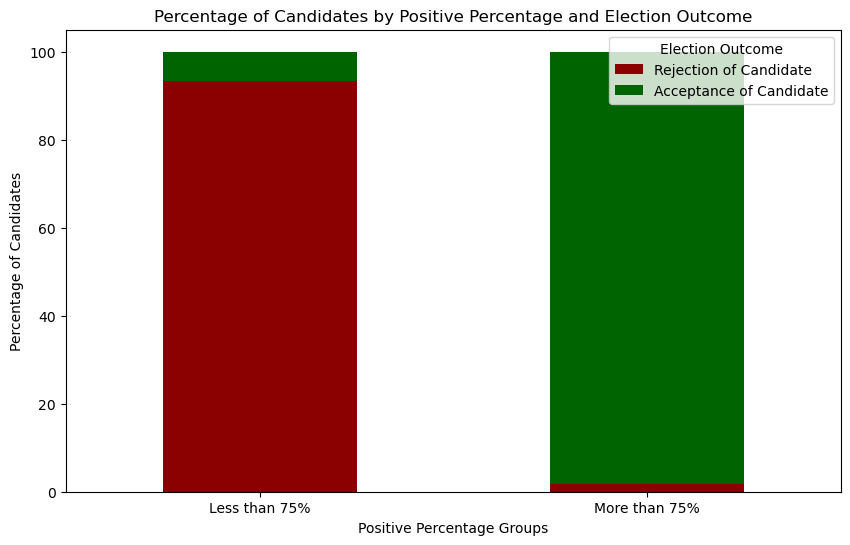

In [83]:
margin_df = elections_df.groupby(elections_df['Positive Percentage'].ge(75).map({True: 'More than 75%', False: 'Less than 75%'}))['RES'].value_counts(normalize=True).unstack() * 100

ax = margin_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['darkred', 'darkgreen'])

plt.xlabel('Positive Percentage Groups')
plt.ylabel('Percentage of Candidates')
plt.title('Percentage of Candidates by Positive Percentage and Election Outcome')
plt.legend(title='Election Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'])
plt.xticks(rotation=0)

plt.show()

In [84]:
margin_df

RES,0,1
Positive Percentage,,
Less than 75%,93.339632,6.660368
More than 75%,1.656543,98.343457


In summary, aspiring administrators should target a positive margin, as over $98\%$ of successful candidates exceed the indicative threshold of $75\%$ positive votes.

In [85]:
won_elections_distribution = elections_df[elections_df['RES'] == 1]['positive_percentage']
ccdf = 1 - won_elections_distribution.value_counts().sort_index().cumsum() / len(won_elections_distribution) 

plt.plot(ccdf.index, ccdf, marker='o', linestyle='-')
plt.xlabel('Percentage of Positive Votes')
plt.ylabel('CDF (Cumulative Percentage of Positive Votes)')
plt.title('CDF of Percentage of Positive Votes in Successful Elections')
plt.grid(True)
plt.show()

KeyError: 'positive_percentage'

In [ ]:
lost_elections_distribution = elections_df[elections_df['RES'] == 0]['Negative Percentage']
ccdf = 1 - lost_elections_distribution.value_counts().sort_index().cumsum() / len(lost_elections_distribution) 

plt.plot(ccdf.index, ccdf, marker='o', linestyle='-')
plt.xlabel('Percentage of Negative Votes')
plt.ylabel('CDF (Cumulative Percentage of Negative Votes)')
plt.title('CDF of Percentage of Negative Votes in Lost Elections')
plt.grid(True)
plt.show()

We notice that 80% of won elections have gathered more than 80% of positive votes, while 80% of lost elections had more than 30% of negative votes. This tells us that positive votes are important for the success of an election, but negative votes are not the only reasons a candidate might lose, this highlights the importance of positive votes. Indeed, a candidate might lose not because they have too many negative votes, but rather because they do not have enough positive ones. Hence the pivotal role neutral votes can play, and the importance of understanding why people vote positively, in order to convert the neutral votes into positive ones and change the outcome of an election.

In the third milestone, we will explore how neutral votes can effect the outcome of an election and analyse ways to sway them.

#### Neutral Votes

First, let's look at the distribution of the votes in our dataset.

In [ ]:
vote_counts = wiki_df['VOT'].value_counts()

label_map = {1: 'Positive', 0: 'Neutral', -1: 'Negative'}
vote_labels = [label_map[val] for val in vote_counts.index]

plt.figure(figsize=(8, 8))
plt.pie(vote_counts, labels=vote_labels, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of VOT Counts')
plt.axis('equal') 

plt.show()

We can see that neutral votes represent 6.4% of our total votes.

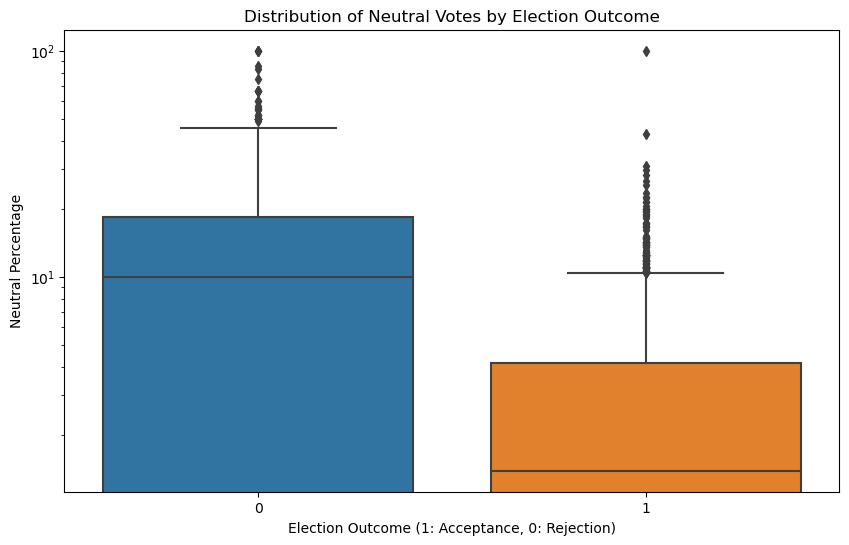

In [86]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='RES', y='Neutral Percentage', data=elections_df)
plt.xlabel('Election Outcome (1: Acceptance, 0: Rejection)')
plt.ylabel('Neutral Percentage')
plt.title('Distribution of Neutral Votes by Election Outcome')
plt.yscale('log')
plt.show()

Observing the boxplot, we notice a notable difference in the distribution of neutral votes between successful and unsuccessful elections. The median for unsuccessful elections is around $10\%$, while for successful elections, it is approximately $1\%$. This indicates a tendency for unsuccessful elections to have a higher proportion of neutral votes.

This motivates our project, indeed, by analysing the motives behind voting, we could possibly be able to change neutral votes into positive ones, changing the outcome of an election.

To confirm this observation, we will conduct a statistical test.

In [87]:
plt.figure(figsize=(10, 6))

sns.barplot(x='YEA', y='Neutral Percentage', hue='RES', data=elections_df)

plt.xlabel('Year')
plt.ylabel('Neutral Percentage')
plt.yscale('log')
plt.title('Neutral Percentage by Year and Election Outcome')

legend = plt.legend(title='Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'])
legend.legendHandles[0].set_color(sns.color_palette()[0])
legend.legendHandles[1].set_color(sns.color_palette()[1])

plt.show()

ValueError: Could not interpret input 'YEA'

<Figure size 1000x600 with 0 Axes>

We notice that this holds true for all years and that there no drastic differences between years.

#### Influence of previous participation before running for adminship

For each candidate, we investigate the votes they cast before the start date of their election. We gather information on the total number of positive, negative, and neutral votes the candidate made, along with the average length of the comments they provided.

In [88]:
def summarize_before_adminship(row):
    election_id = row['ELECTION_ID']
    candidate = row['TGT']
    start_date = row['Earliest Voting Date']
    res = row['RES']
    
    candidate_votes_before = wiki_df[(wiki_df['SRC'] == candidate) & (wiki_df['DAT'] < start_date)]
    
    num_votes_no = (candidate_votes_before['VOT'] == -1).sum()
    num_votes_yes = (candidate_votes_before['VOT'] == 1).sum()
    num_votes_neutral = (candidate_votes_before['VOT'] == 0).sum()
    
    avg_comment_length = candidate_votes_before['TXT'].str.len().mean()
    
    return pd.Series({
        'ELECTION_ID': election_id,
        'TGT': candidate,
        'RES': res,
        'TotalNumPrevVotes' : num_votes_no + num_votes_yes + num_votes_neutral,
        'NumPrevVotesNo': num_votes_no,
        'NumPrevVotesYes': num_votes_yes,
        'NumPrevVotesNeutral': num_votes_neutral,
        'AvgPrevCommentLength': avg_comment_length
    })


summary_before_adminship_df = elections_df[['ELECTION_ID', 'TGT', 'RES', 'Earliest Voting Date']].drop_duplicates()
summary_before_adminship_df = summary_before_adminship_df.apply(summarize_before_adminship, axis=1)

In [89]:
summary_before_adminship_df['AvgPrevCommentLength'] = summary_before_adminship_df['AvgPrevCommentLength'].fillna(0)

summary_before_adminship_df

,ELECTION_ID,TGT,RES,TotalNumPrevVotes,NumPrevVotesNo,NumPrevVotesYes,NumPrevVotesNeutral,AvgPrevCommentLength
0,1,BDD,1,3,0,2,1,250.666667
1,2,Bilby,1,11,3,7,1,568.181818
2,3,Darkwind,1,0,0,0,0,0.000000
3,4,INeverCry,1,8,2,6,0,74.375000
4,5,Jason Quinn,1,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...
3923,3924,Tristanb,1,0,0,0,0,0.000000
3924,3925,Ugen64,1,0,0,0,0,0.000000
3925,3926,Vancouverguy,1,0,0,0,0,0.000000
3926,3927,WhisperToMe,1,0,0,0,0,0.000000


Now that we have the necessary information, we categorize the candidate into two groups: 'Without Previous Votes' if the candidate did not participate as a voter in any election before the beginning of their election and 'With Previous Votes' otherwise.

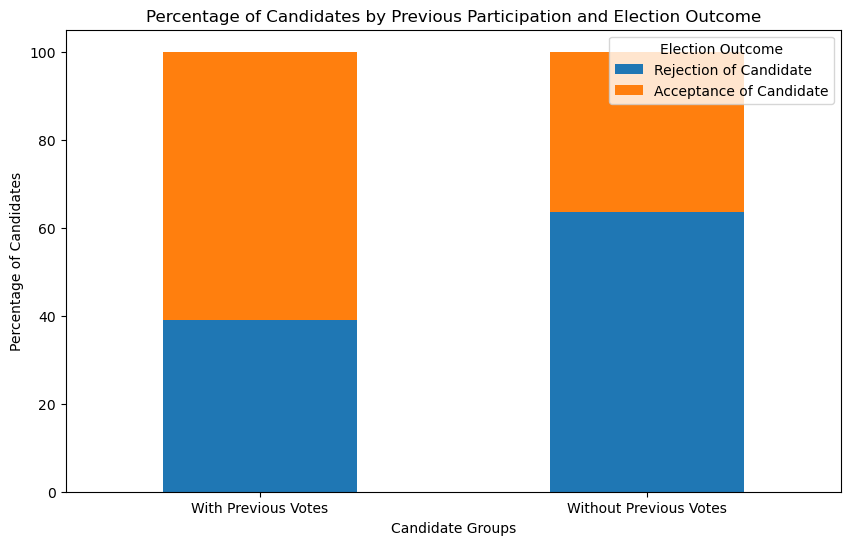

In [90]:
percentage_df = summary_before_adminship_df.groupby(summary_before_adminship_df['TotalNumPrevVotes'].eq(0).map({True: 'Without Previous Votes', False: 'With Previous Votes'}))['RES'].value_counts(normalize=True).unstack() * 100

ax = percentage_df.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Candidate Groups')
plt.ylabel('Percentage of Candidates')
plt.title('Percentage of Candidates by Previous Participation and Election Outcome')
plt.legend(title='Election Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'])
plt.xticks(rotation=0)

plt.show()

In [91]:
percentage_df

RES,0,1
TotalNumPrevVotes,,
With Previous Votes,38.980510,61.019490
Without Previous Votes,63.622211,36.377789


The bar chart reveals a contrast between candidates with prior participation in the voting process and those without. Notably, 61% of candidates with previous engagement were successfully accepted as administrators, whereas only 36% of candidates lacking prior participation received the same outcome.

To validate this observed difference statistically, let's conduct a hypothesis test.

Since we are comparing acceptance rates (a binary outcome) based on a categorical variable (previous participation), a chi-square test for independence is more suitable as it is used when analyzing the association between two categorical variables.

In [92]:
chi2, p, _, _ = chi2_contingency(percentage_df)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

Chi-square statistic: 11.186178160495032
P-value: 0.0008240891240052477


At a significance level of 0.05, the p-value falls below this threshold. Therefore, with 95% confidence, we reject the null hypothesis. This indicates a significant difference in acceptance rates between candidates with and without previous participation in the voting process.

Let's now condider the candidates who participated at least once in the previous elections before his request for adminship. Do the number of positive, negative or neutral votes they made or the length of the comments impact the result of their election?

In [93]:
tgt_with_prev_participation = summary_before_adminship_df[summary_before_adminship_df['TotalNumPrevVotes'] > 0]

C:\Users\liand\AppData\Local\Temp\ipykernel_148144\2473272794.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color(sns.color_palette()[0])
C:\Users\liand\AppData\Local\Temp\ipykernel_148144\2473272794.py:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1].set_color(sns.color_palette()[1])
C:\Users\liand\AppData\Local\Temp\ipykernel_148144\2473272794.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color(sns.color_palette()[0])
C:\Users\liand\AppData\Local\Temp\ipykernel_148144\2473272794.py:19: MatplotlibDeprecationWarning: The legendHandles a

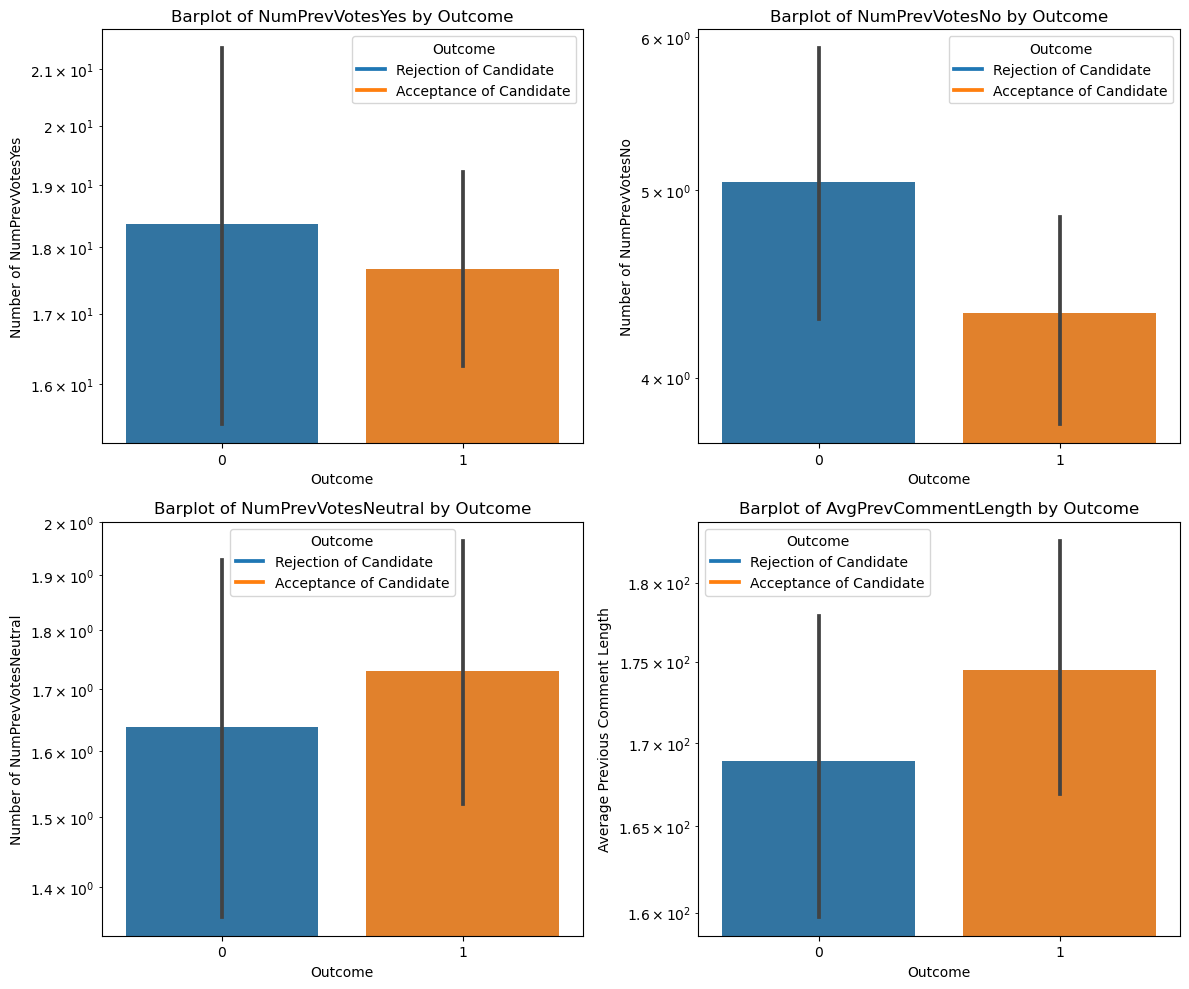

In [94]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Categories to plot
categories = ['NumPrevVotesYes', 'NumPrevVotesNo', 'NumPrevVotesNeutral', 'AvgPrevCommentLength']

for i, category in enumerate(categories):
    row = i // 2
    col = i % 2

    sns.barplot(x='RES', y=category, data=tgt_with_prev_participation, ax=axes[row, col])

    axes[row, col].set_ylabel(f'Number of {category}' if 'NumPrevVotes' in category else 'Average Previous Comment Length')
    axes[row, col].set_xlabel('Outcome')
    axes[row, col].set_title(f'Barplot of {category} by Outcome')
    axes[row, col].set_yscale('log')

    legend = axes[row, col].legend(title='Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'])
    legend.legendHandles[0].set_color(sns.color_palette()[0])
    legend.legendHandles[1].set_color(sns.color_palette()[1])

plt.tight_layout()

plt.show()

Upon examining the bar plot for candidates with prior voting experience, it seems that the average number of previous positive, negative, or neutral votes, as well as the average comment length before their candidacy, is consistent regardless of acceptance or rejection.

To validate these observations, let's conduct a t-test to statistically confirm the similarity between accepted and rejected candidates.

In [95]:
t_test_results = {}

for category in categories:
    data_res_0 = tgt_with_prev_participation[tgt_with_prev_participation['RES'] == 0][category].dropna()
    data_res_1 = tgt_with_prev_participation[tgt_with_prev_participation['RES'] == 1][category].dropna()

    t_stat, p_value = ttest_ind(data_res_0, data_res_1, alternative='two-sided')

    t_test_results[category] = {'T-statistic': t_stat, 'P-value': p_value}
    
for category, result in t_test_results.items():
    print(f"Category: {category}")
    print(f"T-statistic: {result['T-statistic']}")
    print(f"P-value: {result['P-value']}")
    print()

Category: NumPrevVotesYes
T-statistic: 0.43884699900576585
P-value: 0.6608198290092218

Category: NumPrevVotesNo
T-statistic: 1.5819644296167288
P-value: 0.11381588454628705

Category: NumPrevVotesNeutral
T-statistic: -0.49770651236585023
P-value: 0.6187456606353676

Category: AvgPrevCommentLength
T-statistic: -0.8820169915910627
P-value: 0.37787366238526654



The statistical results reveal no substantial differences in the averages, both for the various categories of votes (positive, neutral, or negative) and the length of comments. This leads to the conclusion that candidates' prior voting behavior and comment length, before aspiring to adminship, may not significantly influence the outcome of their candidacy. 

#### Natural Language Processing

##### Sentiment analysis with Vader

Punctuation can provide valuable context for sentiment analysis as it can affect the emotional toned of a sentence. We will keep it then since Vader is designed to work with text including punctuation. It takes into account various linguistic and grammatical aspects to understand the sentiment expressed in a piece of text.

In [66]:
wiki_copy = wiki_df.copy()

In [67]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\liand\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [68]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

* Let's apply it on an example comment.

In [69]:
ex = wiki_copy.iloc[5]['CLE']
print(ex)
print('Scores = ', sia.polarity_scores(ex),end='\n')

Support There are plenty of important roles on this project, of which content creator is only one of them. BDD has done good work over a number of years. That his primary activity is not content creation is not of concern.
Scores =  {'neg': 0.04, 'neu': 0.769, 'pos': 0.191, 'compound': 0.7083}


VADER sentiment analysis provides sentiment scores for text: negative(neg), neutral(neu), positive(pos) and compound scores. 

The compound score takes values from -1 to 1, with values closer to -1 indicating negativity, 0 for neutrality and 1 for positivity. 

In [70]:
scores = {}
for i, row in wiki_copy.iterrows(): 
    scores[i] = sia.polarity_scores(row['CLE'])

In [71]:
scores_df = pd.DataFrame(scores).T

In [72]:
scores_df.head(10)

,neg,neu,pos,compound
0,0.000,0.426,0.574,0.4019
1,0.000,0.426,0.574,0.4019
2,0.000,0.426,0.574,0.4019
3,0.176,0.504,0.320,0.6124
4,0.000,0.612,0.388,0.9349
5,0.040,0.769,0.191,0.7083
6,0.000,0.722,0.278,0.4019
7,0.022,0.848,0.130,0.8850
8,0.058,0.665,0.278,0.9801
9,0.172,0.391,0.437,0.5267


In [73]:
# Merge the two dataframes
wiki_with_scores = pd.concat([wiki_copy, scores_df], axis = 1)
wiki_with_scores.sample(10)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE,neg,neu,pos,compound
105353,Finnrind,Samulili,1,1,2007,2007-09-28 12:26:00,"'''Support''' I know this user from Commons, a...",1665,"Support I know this user from Commons, and I'm...",0.000,0.753,0.247,0.8591
22870,Dank,Joe Decker,1,1,2010,2010-07-24 15:20:00,"Long time user, no problems, and your dedicati...",300,"Long time user, no problems, and your dedicati...",0.206,0.672,0.122,-0.2500
107355,VirtualSteve,ST47,1,1,2007,2007-07-18 07:09:00,'''Support''' - I think the editor is ready. --,1697,Support - I think the editor is ready.,0.000,0.435,0.565,0.6369
76875,Black Kite,Jamesontai,1,0,2008,2008-01-21 23:22:00,"Premature RfA, but '''Moral Support''' per Wiz...",1152,"Premature RfA, but Moral Support per Wizardman...",0.000,0.693,0.307,0.5499
147377,Xoloz,Sandstein,1,1,2006,2006-11-24 23:33:00,'''Support''' Excellent editor with firm grasp...,2467,Support Excellent editor with firm grasp of po...,0.000,0.484,0.516,0.7506
257,Tyrol5,Bilby,1,1,2013,2013-05-30 21:13:00,I've had a look through your editing history a...,2,I've had a look through your editing history a...,0.000,0.708,0.292,0.9836
89846,Wpktsfs,Ck lostsword,1,1,2007,2007-06-11 22:48:00,'''Support''' I don't see why not. Sufficient ...,1429,Support I don't see why not. Sufficient answer...,0.000,0.690,0.310,0.4019
182666,Exir Kamalabadi,Redux,1,1,2005,NaT,'''Support''' I think Redux will be a trustwor...,3288,Support I think Redux will be a trustworthy an...,0.000,0.678,0.322,0.8591
52191,NaN,Tango,-1,0,2009,NaT,,766,,0.000,0.000,0.000,0.0000
42806,Theleftorium,Steve,1,1,2009,2009-08-09 21:29:00,'''Support''' per Andy Walsh and SandyGeorgia....,582,Support per Andy Walsh and SandyGeorgia. Great...,0.000,0.491,0.509,0.8854


In [74]:
# Replace empty comments by NaN
# in order to remove them 
wiki_with_scores['CLE'].replace('', np.nan, inplace=True) 
wiki_with_scores['CLE'].isnull().sum()

9387

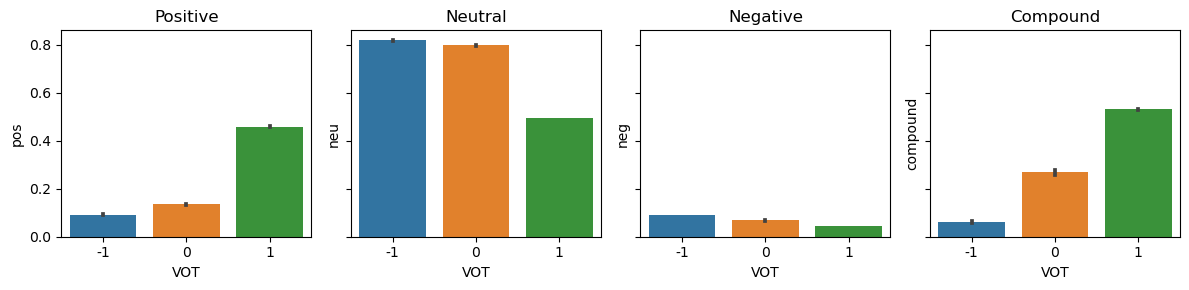

In [75]:
wiki_cle_dropna = wiki_with_scores.dropna(subset = 'CLE') # remove empty comments 
fig, axs = plt.subplots(1, 4, figsize=(12, 3),  sharey = True)
sns.barplot(data=wiki_cle_dropna, x='VOT', y='pos', ax=axs[0])
sns.barplot(data=wiki_cle_dropna, x='VOT', y='neu', ax=axs[1])
sns.barplot(data=wiki_cle_dropna, x='VOT', y='neg', ax=axs[2])
sns.barplot(data=wiki_cle_dropna, x='VOT', y='compound', ax=axs[3])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
axs[3].set_title('Compound')
plt.tight_layout()
plt.show()

Considering the Compound score that merges negative, neutral and positive scores, we can conclude that there is consistency on average between the votes and the associated comments.

In [76]:
compound_per_year = wiki_cle_dropna.groupby(['YEA', 'VOT'])['compound'].mean().reset_index()
compound_per_year.head(9)

,YEA,VOT,compound
0,2003,-1,-0.020150
1,2003,0,0.000000
2,2003,1,0.466455
3,2004,-1,0.076583
4,2004,0,0.192388
5,2004,1,0.399298
6,2005,-1,0.058232
7,2005,0,0.254654
8,2005,1,0.493900


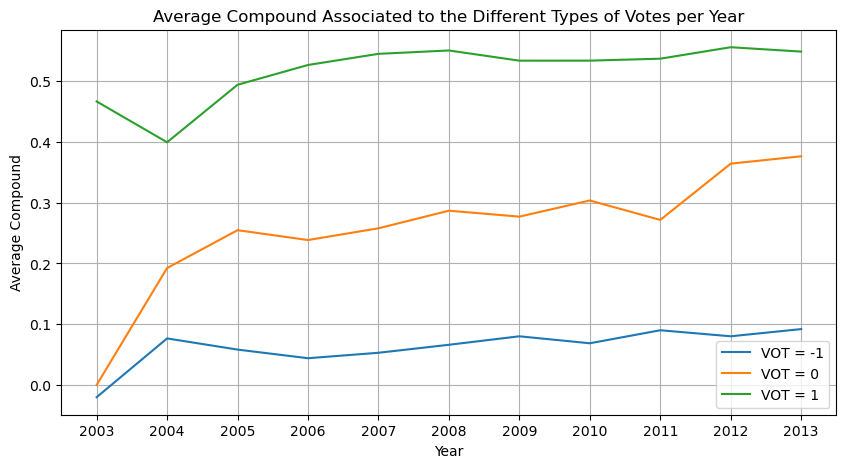

In [77]:
plt.figure(figsize=(10, 5))

for vot in [-1, 0, 1]: 
    sub_df = compound_per_year[compound_per_year['VOT'] == vot]
    plt.plot(sub_df['YEA'], sub_df['compound'], label = 'VOT = '+ str(vot))

plt.title('Average Compound Associated to the Different Types of Votes per Year')
plt.xticks(np.arange(2003, 2014))
plt.xlabel('Year')
plt.ylabel('Average Compound')
plt.grid()
plt.legend()

* For each year, the conclusion of consistency is still available. Therefore, generally, people tend to leave comments accordingly to their vote choice.

##### Sentiment analysis with TextBlob

In this section, we will use TextBlob, a powerful library for processing textual data, in order to extract the sentiment polarity and subjectivity of each comment.

**Notes:** 
* The *polarity* ranges from -1 (indicating negativity) to 1 (indicating positivity)
* The *subjectivity* ranges from 0 (reflecting objectivity) and 1 (reflecting subjectivity).

To achieve that, we have to do additional processing on the comments. 

In [78]:
wiki_copy['CLE'] = wiki_copy['CLE'].apply(nlp_pipeline) 
wiki_copy.head()

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,1,support as conom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,1,support as nominator.
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,1,support per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,support per noms. bdd is a strong contributor ...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,support with great pleasure. i work with bdd a...


In [79]:
# Remove the first word of each comment if contained on the list below
# to avoid a bias on the algorithm
wiki_copy['CLE'] = wiki_copy['CLE'].str.replace('^(support|oppose|neutral|strong support|weak support|happy support|unfortunate oppose) ', '', regex=True)
wiki_copy.head()

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,1,as conom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,1,as nominator.
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,1,per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,per noms. bdd is a strong contributor with tho...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,with great pleasure. i work with bdd at the wh...


In [80]:
# Show the first 10 comments completely
pd.set_option('display.max_colwidth', None)
print(wiki_copy['CLE'].head(10))
pd.reset_option('display.max_colwidth')

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  as conom.
1                                                                                                                                                                                                                                                                                                                                                                          

In [81]:
def polarity(text):  
    '''extracts the polarity of the text sentiment'''
    pol = TextBlob(text)
    return pol.sentiment.polarity

def subjectivity(text):
    '''extracts the subjectivity of the text sentiment'''
    pol = TextBlob(text)
    return pol.sentiment.subjectivity

In [82]:
# Add the polarity and the subjectivity to our dataframe
wiki_copy['polarity'] = wiki_copy['CLE'].apply(polarity)
wiki_copy['subjectivity'] = wiki_copy['CLE'].apply(subjectivity)
wiki_copy.head()

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE,polarity,subjectivity
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,1,as conom.,0.000000,0.000000
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,1,as nominator.,0.000000,0.000000
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,1,per noms.,0.000000,0.000000
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,per noms. bdd is a strong contributor with tho...,0.341667,0.491667
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,with great pleasure. i work with bdd at the wh...,0.638889,0.616667


When we look at the 3 first comments, they have 0 as polarity and 0 as subjectivity. The algorithm does not get any information from comments that are too short or meaningless. Therefore, we are going to show the distribution of the polarity for different levels of subjectivity.

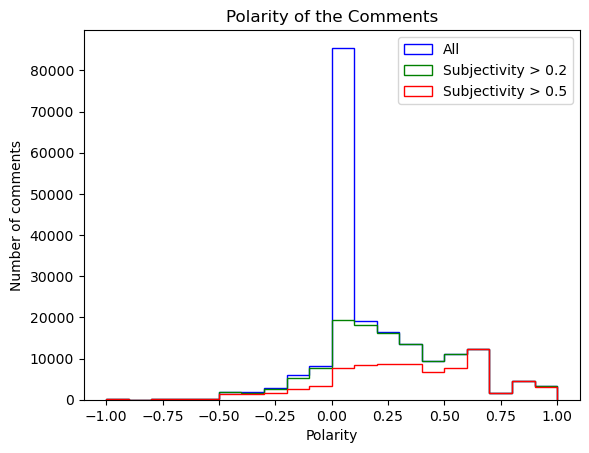

In [83]:
fig,ax = plt.subplots()
ax.hist(wiki_copy["polarity"],bins=20, histtype="step", label='All',color='b')
wiki_copy_subjectif = wiki_copy[wiki_copy['subjectivity'] > 0.2] 
ax.hist(wiki_copy_subjectif["polarity"],bins=20, histtype="step", label='Subjectivity > 0.2',color='g')
wiki_copy_subjectif = wiki_copy[wiki_copy['subjectivity'] > 0.5] 
ax.hist(wiki_copy_subjectif["polarity"],bins=20, histtype="step", label='Subjectivity > 0.5',color='r')
plt.xlabel('Polarity')
plt.ylabel('Number of comments')
plt.title('Polarity of the Comments')
plt.legend()
plt.show()

We observe that many comments show a polarity of 0 indicating a lack of subjectivity. We suppose that they are too brief to provide any interesting information. So to explore this further, we need to display the comments length for each level of subjectivity.

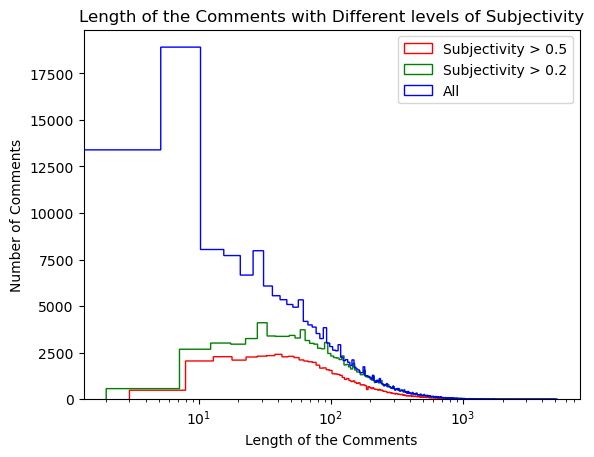

In [84]:
# Graph of the length of the comments for all the comments ( in blue) 
# and for the subjective comments (with subjectivity score more than 0.2 in green and 0.5 in red)
fig,ax = plt.subplots() 
ax.hist(wiki_copy[wiki_copy['subjectivity'] > 0.5]['CLE'].str.len(),bins=1000, histtype="step", label='Subjectivity > 0.5',color='r')
ax.hist(wiki_copy[wiki_copy['subjectivity'] > 0.2]['CLE'].str.len(),bins=1000, histtype="step", label='Subjectivity > 0.2',color='g')
ax.hist(wiki_copy['CLE'].str.len(),bins=1000, histtype="step", label='All',color='b')
plt.xlabel('Length of the Comments')
plt.ylabel('Number of Comments')
plt.title('Length of the Comments with Different levels of Subjectivity')
plt.xscale('log')
plt.legend()
plt.show()

Many comments appear too brief to provide substantial information. To ensure meaningful insights, we have established a subjectivity threshold of 0.2. Consequently, during our comment exploration, we exclusively utilize the subjective dataframe. Our objective is to enhance the quality of our results by keeping only those comments that are considered more interesting and informative.

In [85]:
# new dataframe with only subjective comments for the rest of our analysis
df_subjectiv = wiki_copy[wiki_copy['subjectivity'] > 0.2] 

###### Length of the comments

In this part, we explore the correlation between the length of the comment and the subjectivity.

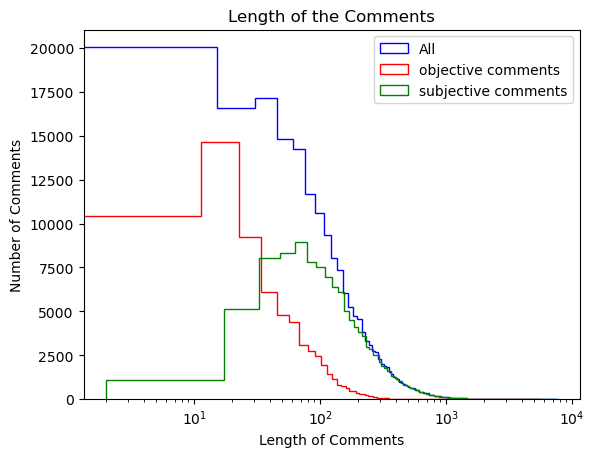

In [86]:
fig,ax = plt.subplots() 
ax.hist(wiki_copy['TXT'].str.len(),bins=500, histtype="step", label='All',color='b')
ax.hist(wiki_copy[wiki_copy['subjectivity'] < 0.2]['TXT'].str.len(),bins=500, histtype="step", label='objective comments',color='r')
ax.hist(wiki_copy[wiki_copy['subjectivity'] > 0.2]['TXT'].str.len(),bins=500, histtype="step", label='subjective comments',color='g')
plt.xlabel('Length of Comments')
plt.ylabel('Number of Comments')
plt.xscale('log')
plt.legend()
plt.title('Length of the Comments')
plt.show()

We note that typically, when a comment is excessively brief, it tends to be objective. Conversely, when a comment is more extensive in terms of characters, it is likely to be subjective.

##### Topic of the comments

In this part, we will use the latent dirichlet allocation in order to cluster the comments in various topics. The main idea is to extract some interesting keywords from the comments, so that we can understand what are the criteria to achieve a successful election.

We start with processing text with spacy.

In [87]:
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [88]:
def preprocess_text(text):
    ''' preprocesses text with lemmatization'''
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return " ".join(tokens)

In [89]:
def process_stop_word(text, stem="None"):
    '''removes stop words'''
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']
    text_filtered = [word for word in text if not word in useless_words]
        # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string

In [90]:
# Clean the text for the LDA algorithm
df_subjectiv['preprocessed_txt'] = df_subjectiv['CLE'].apply(preprocess_text)
df_subjectiv['preprocessed_txt'] = df_subjectiv['preprocessed_txt'].apply(process_stop_word)

C:\Users\liand\AppData\Local\Temp\ipykernel_4312\2082174653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subjectiv['preprocessed_txt'] = df_subjectiv['CLE'].apply(preprocess_text)
C:\Users\liand\AppData\Local\Temp\ipykernel_4312\2082174653.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subjectiv['preprocessed_txt'] = df_subjectiv['preprocessed_txt'].apply(process_stop_word)


##### Transforming the preprocessed comments into a structured representation that captures the importance of terms within each comment using TF-IDF (Term Frequency-Inverse Document Frequency).

In [91]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
# Apply TF-IDF vectorization to the preprocessed text
dtm = vectorizer.fit_transform(df_subjectiv['preprocessed_txt'])

In [92]:
# LDA model
num_topics = 25 # Classify into n topics to visualize some positive or negative topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)  # Fit the LDA model to the TF-IDF matrix

LatentDirichletAllocation(n_components=25, random_state=42)

In [93]:
def print_top_words(model, vectorizer, n_words=10):
    '''prints the 10 words that are the best of each topics'''
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic #{topic_idx + 1}: {' | '.join(top_words)}")

In [94]:
print_top_words(lda, vectorizer)

Topic #1: ready | glad | attitude | hard | worthy | support | think | supportno | work | adminship
Topic #2: mop | deserve | support | extreme | good | bucket | hand | pleasure | editor | sincerely
Topic #3: positive | net | interaction | responsible | support | strongly | good | user | project | clue
Topic #4: answer | question | vandal | good | guy | fighter | nice | support | choice | great
Topic #5: nom | helpful | friendly | deal | big | good | support | supportgood | user | editor
Topic #6: meet | image | capable | admin | surprised | fair | support | criterion | standard | backlog
Topic #7: edit | low | count | mainspace | experience | space | namespace | month | talk | wikipedia
Topic #8: ok | sense | cheer | admin | common | new | dispute | support | good | think
Topic #9: weak | long | obviously | oppose | major | supporti | support | easy | concern | welcome
Topic #10: edit | summary | active | usage | use | page | good | support | rc | patrol
Topic #11: use | tool | trust |

We can now generate a topic number for all the comments in the dataframe:

In [95]:
# Add a column with the number of the topic for each comment
df_subjectiv.reset_index(drop=True, inplace=True)
df_subjectiv['Topic'] = df_subjectiv.index.map(lambda i: lda.transform(dtm[i]).argmax())
df_subjectiv.head()

C:\Users\liand\AppData\Local\Temp\ipykernel_4312\4101988350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subjectiv['Topic'] = df_subjectiv.index.map(lambda i: lda.transform(dtm[i]).argmax())


,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE,polarity,subjectivity,preprocessed_txt,Topic
0,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,per noms. bdd is a strong contributor with tho...,0.341667,0.491667,nom bdd strong contributor thousand edit year ...,9
1,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,with great pleasure. i work with bdd at the wh...,0.638889,0.616667,great pleasure work bdd coordinator see good w...,16
2,Sven Manguard,BDD,1,1,2013,2013-04-20 01:53:00,'''Support''' There are plenty of important ro...,1,there are plenty of important roles on this pr...,0.375000,0.775000,plenty important role project content creator ...,15
3,RockMagnetist,BDD,1,1,2013,2013-04-20 02:18:00,'''Support''' BDD already wields a broom pret...,1,bdd already wields a broom pretty well so why ...,0.095556,0.502963,bdd wield broom pretty formalize concerned lac...,6
4,Carrite,BDD,1,1,2013,2013-04-20 02:22:00,'''Support''' barring a completely unexpected ...,1,barring a completely unexpected answer to prof...,0.333214,0.529048,bar completely unexpected answer proforma ques...,15


We can visualize the polarity of each topics :

C:\Users\liand\anaconda3\envs\ada\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Polarity of Different Topics')

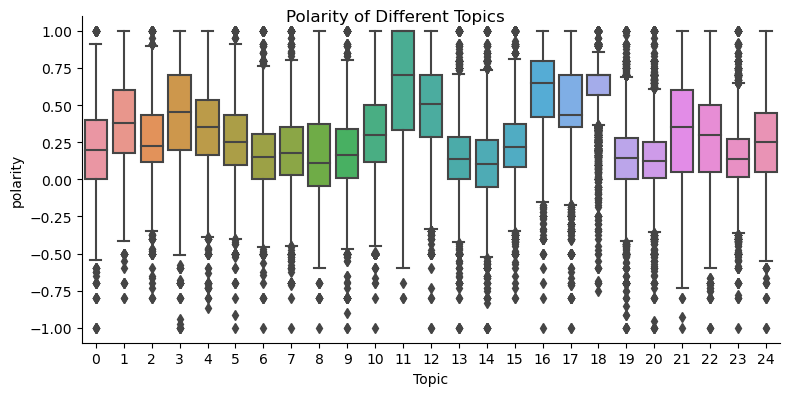

In [96]:
plot = sns.catplot(x='Topic', y='polarity', kind="box", data=df_subjectiv, errorbar='sd', height=4, aspect=2)
plot.fig.suptitle('Polarity of Different Topics')

By examining this plot, it becomes evident that topics 10-11-12 exhibit a higher polarity compared to the others. To delve deeper into the positive comments within this topic, we can inspect the list of prevalent words. Notable keywords include:
- positive
- interaction
- experienced
- helpful
- friendly

After reflection, we anticipate uncovering more insights by filtering comments exclusively for positive or negative sentiments.

##### Repeat the same with the positive/negative comments

In this part, we are gonna use only the subjective comments with a polarity greater than 0,5. The goal is to extract the topics and keywords to gives us an idea of the positive comments.

In [97]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
# Apply TF-IDF vectorization to the preprocessed text
dtm = vectorizer.fit_transform(df_subjectiv[df_subjectiv['polarity'] > 0.5]['preprocessed_txt'])

# LDA model
num_topics = 20 #separation in 20 topics to visualize some positive or negative topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)  # Fit the LDA model to the TF-IDF matrix

LatentDirichletAllocation(n_components=20, random_state=42)

In [98]:
print_top_words(lda, vectorizer)

Topic #1: good | page | judgement | talk | yes | supportgood | edit | work | support | user
Topic #2: tool | use | trust | good | mop | editor | user | admin | wisely | stuff
Topic #3: work | good | deserve | support | happy | lot | great | afd | editor | amazing
Topic #4: wikipedian | asset | thing | wikipedia | great | project | admin | good | wonderful | doubt
Topic #5: look | good | like | support | great | admin | supportall | encounter | productive | load
Topic #6: admin | great | good | vandal | fine | fighter | support | think | sure | editor
Topic #7: editor | good | great | job | support | track | record | person | concern | sensible
Topic #8: contribution | good | choice | interaction | supporti | support | summary | plenty | edit | great
Topic #9: edit | good | appear | addition | mainspace | vandalism | support | admin | great | mop
Topic #10: awesome | welcome | kind | support | say | admin | superb | brilliant | attitude | user
Topic #11: luck | user | good | problem | g

Some other interesting positive words :
- trustworthy
- contribution
- experience
- asset
- friendly
- work
- project 
- fighter 
- helpful 
- ...

These terms serve as valuable criterias to the acceptance of a person.

Then with the negative comments, with polarity smaller than -0,5.

In [99]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
# Apply TF-IDF vectorization to the preprocessed text
dtm = vectorizer.fit_transform(df_subjectiv[df_subjectiv['polarity'] < 0]['preprocessed_txt'])

# LDA model
num_topics = 20 #separation in 20 topics to visualize some positive or negative topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)  # Fit the LDA model to the TF-IDF matrix

LatentDirichletAllocation(n_components=20, random_state=42)

In [100]:
print_top_words(lda, vectorizer)

Topic #1: major | poor | concern | vandalism | block | careful | user | policy | answer | understanding
Topic #2: real | civility | oppose | bad | admin | support | feeling | user | candidate | reason
Topic #3: sorry | inexperienced | article | new | ridiculous | edit | account | oppose | contrib | support
Topic #4: seriously | sure | support | think | supporti | oh | admin | editor | stupid | wrong
Topic #5: bad | silly | crazy | support | oppose | close | afd | agree | admin | vote
Topic #6: oppose | page | signature | support | rfa | user | admin | username | edit | like
Topic #7: oppose | qualified | candidate | concern | support | section | response | user | questionable | random
Topic #8: fail | oppose | rfa | admin | help | need | user | support | pov | article
Topic #9: edit | low | experience | lack | mainspace | count | article | little | contribution | space
Topic #10: big | deal | positive | net | year | support | think | adminship | comfortable | weird
Topic #11: abuse | u

From this word list, we can infer certain criteria indicative of non-acceptance:
- uncivil
- stupid
- immature
- overdue 
- silly 
- inexperienced  


##### Which words are most frequently utilized in the comments?

In [101]:
all_text = ' '.join(df_subjectiv['preprocessed_txt'].astype(str))
all_text_p = ' '.join(df_subjectiv[df_subjectiv['polarity'] > 0.5]['preprocessed_txt'].astype(str))
all_text_n = ' '.join(df_subjectiv[df_subjectiv['polarity'] < -0.5]['preprocessed_txt'].astype(str))

# Tokenize the text into words
words = re.findall(r'\b\w+\b', all_text.lower())
words_p = re.findall(r'\b\w+\b', all_text_p.lower())
words_n = re.findall(r'\b\w+\b', all_text_n.lower())


# count occurrences of each word
word_counts = Counter(words)
word_counts_p = Counter(words_p)
word_counts_n = Counter(words_n)

# Print the most common words and their counts for all/positive/negative comments
print('Most common words in all the comments : \n', word_counts.most_common(20),'\n')
print('Most common words the positive comments : \n', word_counts_p.most_common(20),'\n')
print('Most common words the negative comments : \n', word_counts_n.most_common(20),'\n')

Most common words in all the comments : 
 [('good', 44827), ('support', 41769), ('admin', 35116), ('edit', 26420), ('user', 24785), ('oppose', 23884), ('editor', 22025), ('candidate', 18308), ('work', 18066), ('think', 17112), ('tool', 16240), ('experience', 16122), ('like', 15094), ('answer', 14354), ('time', 14308), ('article', 13735), ('need', 13342), ('rfa', 12845), ('great', 12413), ('question', 12133)] 

Most common words the positive comments : 
 [('good', 18123), ('support', 7265), ('great', 5935), ('admin', 5397), ('editor', 4859), ('user', 4234), ('excellent', 3784), ('candidate', 3092), ('work', 2935), ('look', 2746), ('answer', 2312), ('like', 2079), ('tool', 2068), ('luck', 1921), ('edit', 1703), ('question', 1576), ('contribution', 1566), ('see', 1560), ('think', 1475), ('experience', 1441)] 

Most common words the negative comments : 
 [('bad', 170), ('support', 122), ('oppose', 100), ('admin', 89), ('hate', 51), ('user', 47), ('think', 43), ('tool', 41), ('reason', 40),

##### Categorization with our categories

In this part we want to categorize the comments in some categories. For that we need some examples of words for each of them.

In [102]:
from empath import Empath

lexicon = Empath()

lexicon.create_category("hardskills", ["technical", "skills", "coding", "programming", "debugging", "edit", "administrator", "mediawiki", "templates", "bot", "scripting", "sandbox", "rollback", "protect", "user rights", "scripting", "API", "page deletion", "history merging","administrator role", "mediation", "policy enforcement", "template editing", "bot management", "advanced scripting", "technical expertise", "code review", "user permissions", "database management"])
lexicon.create_category("softskills", ["communication skills", "leadership qualities", "empathetic approach", "conflict resolution skills", "adaptive mindset", "collaborative spirit", "strong interpersonal skills","communication", "teamwork", "leadership", "empathy", "conflict resolution", "adaptability", "collaboration", "interpersonal"])
lexicon.create_category("friendship", ["friendly interactions", "supportive community", "trustworthy friendships", "loyal relationships", "conflict resolution among friends", "betrayal in social circles","friend", "friendly", "companionship", "supportive", "trustworthy", "loyal", "conflict", "betrayal"])
lexicon.create_category("experience", ["vast experience", "deep knowledge", "years of valuable experience", "strong contributor to the community", "thousands of edits made", "novice in the field", "inexperienced user", "lack of experience in certain areas", "inefficient practices","experience", "learned", "knowledge", "years of experience", "strong contributor", "thousands of edits", "novice", "inexperienced", "lack of experience", "inefficient"])
lexicon.create_category("negative_sentiment", ["dislike for certain actions", "disagreement with policies", "hatred towards specific users", "unpleasant interactions", "criticism of certain decisions", "strong opposition", "dislike", "disagree", "hate", "unpleasant", "criticism", "oppose"])


["skills", "learn", "techniques", "professionals", "fighting_skills", "methods", "abilities", "programming", "hone", "strategy", "strategies", "teamwork", "capabilities", "educate", "technique", "missions", "tactics", "method", "talents", "duplicate", "own_benefit", "implement", "potential", "master", "utilize", "potential", "strengths", "research", "weaknesses", "examples", "experts", "secret_weapon", "specialize", "technology", "tactic", "casting", "use", "survival_skills", "creators", "prototype", "basis", "discipline", "succeed", "basics", "program", "remake", "organization", "Therefore", "leadership", "eliminate", "operations", "improve", "special_abilities", "top_priority", "mind_control", "benefit", "invent", "works", "improvise", "self-defense", "experiments", "sponsors", "persuasion", "resource", "compromise", "mindset", "experiment", "establish", "evaluation", "research", "aspects", "development", "utilized", "work", "time_travel", "inventions", "special_ability", "telepathy"

In [103]:
def categorize_comment(comment):
    # Analyze the comment using the created categories
    categories = lexicon.analyze(comment, categories=["hardskills", "softskills", "friendship", "experience", "negative_sentiment"], normalize=True)
    
    # Get the category for the max of all of them
    theme = max(categories, key=categories.get)
    
    return theme

We implement a categorization system by creating a new 'Category' column for each comment. The assignment of a specific category is determined by analyzing the comment across predefined categories such as 'hardskills,' 'softskills,' 'friendship,' 'experience,' and 'negative_sentiment.' The chosen category for each comment is the one with the highest normalized score, providing a comprehensive way to classify comments based on their content and themes.

In [104]:
df_subjectiv['Category'] = df_subjectiv['CLE'].apply(categorize_comment)
df_subjectiv.head(10)

C:\Users\liand\AppData\Local\Temp\ipykernel_4312\2849244820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subjectiv['Category'] = df_subjectiv['CLE'].apply(categorize_comment)


,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE,polarity,subjectivity,preprocessed_txt,Topic,Category
0,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,per noms. bdd is a strong contributor with tho...,0.341667,0.491667,nom bdd strong contributor thousand edit year ...,9,hardskills
1,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,with great pleasure. i work with bdd at the wh...,0.638889,0.616667,great pleasure work bdd coordinator see good w...,16,hardskills
2,Sven Manguard,BDD,1,1,2013,2013-04-20 01:53:00,'''Support''' There are plenty of important ro...,1,there are plenty of important roles on this pr...,0.375000,0.775000,plenty important role project content creator ...,15,hardskills
3,RockMagnetist,BDD,1,1,2013,2013-04-20 02:18:00,'''Support''' BDD already wields a broom pret...,1,bdd already wields a broom pretty well so why ...,0.095556,0.502963,bdd wield broom pretty formalize concerned lac...,6,experience
4,Carrite,BDD,1,1,2013,2013-04-20 02:22:00,'''Support''' barring a completely unexpected ...,1,barring a completely unexpected answer to prof...,0.333214,0.529048,bar completely unexpected answer proforma ques...,15,friendship
5,Someguy1221,BDD,1,1,2013,2013-04-20 03:09:00,'''Support''' because I see no good reason not...,1,because i see no good reason not to.,-0.350000,0.600000,good reason,17,hardskills
6,Secret,BDD,1,1,2013,2013-04-20 03:18:00,'''Support''' if a qualified editor is asking ...,1,if a qualified editor is asking for the tools ...,0.102083,0.622917,qualified editor ask tool work area hardly adm...,10,hardskills
7,Dennis Brown,BDD,1,1,2013,2013-04-20 03:20:00,'''Support''' - I've done a formal review on h...,1,supporti've done a formal review on him previo...,0.310667,0.611111,formal review previously consider nominate sur...,5,hardskills
8,MJ94,BDD,1,1,2013,2013-04-20 03:25:00,'''Support''' From his hard work in copyeditin...,1,from his hard work in copyediting to his kind ...,0.154167,0.720833,hard work copyedit kind helpful personality fu...,4,friendship
9,King of Hearts,BDD,1,1,2013,2013-04-20 03:28:00,'''Support''' Seems to be a good editor. [[Use...,1,seems to be a good editor.,0.700000,0.600000,good editor,18,hardskills


In [105]:
from sklearn.feature_selection import chi2

category_column = 'Category'

# Create a CountVectorizer to convert text data into a bag-of-words representation
vectorizer_pos = CountVectorizer()
vectorizer_neg = CountVectorizer()

# Filter the DataFrame to include only comments with positive polarity
df_pos = df_subjectiv[df_subjectiv['polarity'] > 0.5]
# Filter the DataFrame to include only comments with negative polarity
df_neg = df_subjectiv[df_subjectiv['polarity'] <= 0.5]

# Fit and transform the preprocessed text data for positive polarity comments
X_pos = vectorizer_pos.fit_transform(df_pos['preprocessed_txt'])

# Fit and transform the preprocessed text data for negative polarity comments
X_neg = vectorizer_neg.fit_transform(df_neg['preprocessed_txt'])

# Calculate the chi-squared statistic for each term and category directly on the sparse matrix
chi2_stat_pos, p_val_pos = chi2(X_pos, df_pos[category_column])
chi2_stat_neg, p_val_neg = chi2(X_neg, df_neg[category_column])

# Create DataFrames with chi-squared statistics and corresponding terms
df_chi2_pos = pd.DataFrame({'Term': vectorizer_pos.get_feature_names_out(), 'Chi2': chi2_stat_pos, 'P-Value': p_val_pos})
df_chi2_neg = pd.DataFrame({'Term': vectorizer_neg.get_feature_names_out(), 'Chi2': chi2_stat_neg, 'P-Value': p_val_neg})

# Display the top terms for each category based on chi-squared statistics
top_terms_by_category_pos = {}
top_terms_by_category_neg = {}
threshold = 25  # Threshold

for category in df_subjectiv[category_column].unique():
    condition_pos = (df_pos[category_column] == category)
    top_terms_pos = df_chi2_pos.loc[(df_chi2_pos['Term'].isin(vectorizer_pos.get_feature_names_out()) & condition_pos) & (df_chi2_pos['Chi2'] > threshold)].nlargest(20, 'Chi2')['Term'].tolist()
    top_terms_by_category_pos[category] = top_terms_pos
    print(f"\nTop terms for '{category}' (positive polarity): {', '.join(top_terms_pos)}")

    condition_neg = (df_neg[category_column] == category)
    top_terms_neg = df_chi2_neg.loc[(df_chi2_neg['Term'].isin(vectorizer_neg.get_feature_names_out()) & condition_neg) & (df_chi2_neg['Chi2'] > threshold)].nlargest(20, 'Chi2')['Term'].tolist()
    top_terms_by_category_neg[category] = top_terms_neg
    print(f"\nTop terms for '{category}' (negative polarity): {', '.join(top_terms_neg)}")


Top terms for 'hardskills' (positive polarity): knowledge, ideal, opposition, honestly, wikipedia, section, especially, truly, luck, throught, process, term, ha, concept, killiondude, intelligence, attribute, gwen, adequate, acquire

Top terms for 'hardskills' (negative polarity): experience, conflict, participation, opposition, civil, willingness, opinion, understand, conduct, communication, sensible, vote, area, user, doubt, candidate, significant, think, weak, use

Top terms for 'experience' (positive polarity): bit, glory, necessity, agüeybaná, intellectual, redefine, supportemouse

Top terms for 'experience' (negative polarity): learn, ability, work, point, section, strong, merit, learning, encourage, delete, extent, editing, deal, evidence, level, resolution, vandalism, day, wise, task

Top terms for 'friendship' (positive polarity): kind, agree, neutral, indicate, bjweeks, downtoearth, editorwriter, foster, intentional, kumquat, neutralwikipediaspace, stricken, supportgiven, su

We observe that numerous words may not contribute positively to accurately representing the intended categories. To refine the categorization process, we introduce a threshold for comment acceptance within a category. If a comment lacks sufficient representation of a specific category, it is assigned to the 'other' category, ensuring a more discerning and meaningful classification of comments.

In [106]:
def categorize_comment(comment):
    categories = lexicon.analyze(comment, categories=["hardskills", "softskills", "friendship", "experience", "negative_sentiment"], normalize=True)
    
    # Determine the theme with the highest score
    theme = max(categories, key=categories.get)
    
    # Check if the theme's score is below a certain threshold to consider it not significant
    threshold = 0.1
    if categories[theme] < threshold:
        theme = "other"
    
    return theme


In [107]:
df_subjectiv['Category'] = df_subjectiv['CLE'].apply(categorize_comment)
df_subjectiv.head(10)

C:\Users\liand\AppData\Local\Temp\ipykernel_4312\2849244820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subjectiv['Category'] = df_subjectiv['CLE'].apply(categorize_comment)


,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE,polarity,subjectivity,preprocessed_txt,Topic,Category
0,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,per noms. bdd is a strong contributor with tho...,0.341667,0.491667,nom bdd strong contributor thousand edit year ...,9,other
1,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,with great pleasure. i work with bdd at the wh...,0.638889,0.616667,great pleasure work bdd coordinator see good w...,16,other
2,Sven Manguard,BDD,1,1,2013,2013-04-20 01:53:00,'''Support''' There are plenty of important ro...,1,there are plenty of important roles on this pr...,0.375000,0.775000,plenty important role project content creator ...,15,other
3,RockMagnetist,BDD,1,1,2013,2013-04-20 02:18:00,'''Support''' BDD already wields a broom pret...,1,bdd already wields a broom pretty well so why ...,0.095556,0.502963,bdd wield broom pretty formalize concerned lac...,6,other
4,Carrite,BDD,1,1,2013,2013-04-20 02:22:00,'''Support''' barring a completely unexpected ...,1,barring a completely unexpected answer to prof...,0.333214,0.529048,bar completely unexpected answer proforma ques...,15,other
5,Someguy1221,BDD,1,1,2013,2013-04-20 03:09:00,'''Support''' because I see no good reason not...,1,because i see no good reason not to.,-0.350000,0.600000,good reason,17,other
6,Secret,BDD,1,1,2013,2013-04-20 03:18:00,'''Support''' if a qualified editor is asking ...,1,if a qualified editor is asking for the tools ...,0.102083,0.622917,qualified editor ask tool work area hardly adm...,10,other
7,Dennis Brown,BDD,1,1,2013,2013-04-20 03:20:00,'''Support''' - I've done a formal review on h...,1,supporti've done a formal review on him previo...,0.310667,0.611111,formal review previously consider nominate sur...,5,other
8,MJ94,BDD,1,1,2013,2013-04-20 03:25:00,'''Support''' From his hard work in copyeditin...,1,from his hard work in copyediting to his kind ...,0.154167,0.720833,hard work copyedit kind helpful personality fu...,4,friendship
9,King of Hearts,BDD,1,1,2013,2013-04-20 03:28:00,'''Support''' Seems to be a good editor. [[Use...,1,seems to be a good editor.,0.700000,0.600000,good editor,18,other


In [138]:
# Print the number of comments for each theme
theme_counts = df_subjectiv['Category'].value_counts()
print(theme_counts)

Category
other                 121169
friendship              2814
negative_sentiment      2425
hardskills              1686
experience               997
softskills               334
Name: count, dtype: int64


While it's true that we lose a portion of comments by setting a threshold, it's important to note that the remaining comments assigned to a category tend to offer more meaningful representation. The decision to filter out comments below the threshold ensures that the included comments have a stronger association with the specified categories, contributing to a more accurate and focused categorization.

In [109]:
categories = ["hardskills", "softskills", "friendship", "experience", "negative_sentiment", "other"]

vectorizer = TfidfVectorizer(min_df=1, max_df=0.9, stop_words='english')

top_terms_by_category = {}

# Iterate through each category
for category in categories:
    # Filter comments for the current category
    condition = (df_subjectiv['Category'] == category)
    comments_category = df_subjectiv[condition]['preprocessed_txt'].tolist()
    
    # Apply TF-IDF vectorization
    X = vectorizer.fit_transform(comments_category)
    
    feature_names = vectorizer.get_feature_names_out()
    
    tfidf_scores = X.sum(axis=0).A1
    
    df_tfidf = pd.DataFrame({'Term': feature_names, 'TF-IDF': tfidf_scores})
    
    # Select top terms based on TF-IDF scores
    top_terms = df_tfidf.nlargest(20, 'TF-IDF')['Term'].tolist()
    
    top_terms_by_category[category] = top_terms
    
    # Print top terms for the current category
    print(f"\nTop terms for '{category}': {', '.join(top_terms)}")


Top terms for 'hardskills': work, good, use, support, tool, great, excellent, editor, user, admin, article, mop, potential, edit, wisely, benefit, candidate, lot, wikipedia, experience

Top terms for 'softskills': good, knowledge, support, contribution, policy, opposition, participation, great, conflict, excellent, editor, edit, involvement, communication, history, admin, user, wikipedia, strong, concern

Top terms for 'friendship': good, support, editor, trustworthy, user, trust, helpful, responsible, admin, friendly, contributor, luck, great, civil, candidate, tool, sensible, especially, excellent, kind

Top terms for 'experience': experience, need, good, support, user, oppose, admin, candidate, lack, editor, positive, ideal, edit, little, sorry, concern, great, knowledge, answer, area

Top terms for 'negative_sentiment': like, good, oppose, look, candidate, strong, support, admin, user, great, weak, editor, fine, agree, need, reason, excellent, answer, edit, experience

Top terms f

Now, our objective is to examine whether there are discernible differences in the choice of words between comments with positive and negative polarity (considering a threshold of +/- 0.5). This analysis aims to uncover distinctive language patterns associated with sentiments, providing insights into the vocabulary variations between positively and negatively polarized comments.

In [110]:
categories = ["hardskills", "softskills", "friendship", "experience", "negative_sentiment", "other"]

vectorizer = TfidfVectorizer(min_df=1, max_df=0.9, stop_words='english')

top_terms_by_category = {}

# Iterate through each category
for category in categories:
    # Filter comments for the current category and positive polarity
    condition_pos = (df_subjectiv['Category'] == category) & (df_subjectiv['polarity'] > 0.5)
    comments_category_pos = df_subjectiv[condition_pos]['preprocessed_txt'].tolist()
    
    X_pos = vectorizer.fit_transform(comments_category_pos)
    
    feature_names_pos = vectorizer.get_feature_names_out()
    
    tfidf_scores_pos = X_pos.sum(axis=0).A1
    
    df_tfidf_pos = pd.DataFrame({'Term': feature_names_pos, 'TF-IDF': tfidf_scores_pos})
    
    # Select top terms based on TF-IDF scores
    top_terms_pos = df_tfidf_pos.nlargest(10, 'TF-IDF')['Term'].tolist()
    
    top_terms_by_category[f'{category}_positive'] = top_terms_pos
    
    # Print top terms for the current category and positive polarity
    print(f"\nTop terms for '{category}' (positive polarity): {', '.join(top_terms_pos)}")
    
    # Filter comments for the current category and negative polarity
    condition_neg = (df_subjectiv['Category'] == category) & (df_subjectiv['polarity'] <= 0.5)
    comments_category_neg = df_subjectiv[condition_neg]['preprocessed_txt'].tolist()
    
    X_neg = vectorizer.fit_transform(comments_category_neg)
    
    feature_names_neg = vectorizer.get_feature_names_out()
    
    tfidf_scores_neg = X_neg.sum(axis=0).A1
    
    df_tfidf_neg = pd.DataFrame({'Term': feature_names_neg, 'TF-IDF': tfidf_scores_neg})
    
    # Select top terms based on TF-IDF scores
    top_terms_neg = df_tfidf_neg.nlargest(30, 'TF-IDF')['Term'].tolist()
    
    top_terms_by_category[f'{category}_negative'] = top_terms_neg
    
    # Print top terms for the current category and negative polarity
    print(f"\nTop terms for '{category}' (negative polarity): {', '.join(top_terms_neg)}")


Top terms for 'hardskills' (positive polarity): good, work, use, great, tool, support, excellent, editor, user, admin

Top terms for 'hardskills' (negative polarity): work, use, good, support, tool, admin, great, potential, edit, editor, user, article, summary, wikipedia, far, benefit, experience, need, definitely, hard, candidate, strong, skill, useful, mop, improve, like, learn, oppose, responsibly

Top terms for 'softskills' (positive polarity): good, contribution, support, great, knowledge, excellent, policy, history, participation, editor

Top terms for 'softskills' (negative polarity): knowledge, support, good, opposition, policy, conflict, contribution, participation, edit, oppose, concern, admin, user, strong, editor, conduct, involvement, need, experience, primarily, communication, wikipedia, resolve, potential, poor, excellent, raise, candidate, project, history

Top terms for 'friendship' (positive polarity): good, editor, support, user, trustworthy, trust, luck, great, adm

As for the votes categorized as positive or negative...

In [111]:
categories = ["hardskills", "softskills", "friendship", "experience", "negative_sentiment", "other"]

vectorizer = TfidfVectorizer(min_df=1, max_df=0.9, stop_words='english')

top_terms_by_category = {}

# Iterate through each category
for category in categories:
    # Filter comments for the current category and positive polarity
    condition_pos = (df_subjectiv['Category'] == category) & (df_subjectiv['VOT'] == 1)
    comments_category_pos = df_subjectiv[condition_pos]['preprocessed_txt'].tolist()
    
    X_pos = vectorizer.fit_transform(comments_category_pos)
    
    feature_names_pos = vectorizer.get_feature_names_out()
    
    tfidf_scores_pos = X_pos.sum(axis=0).A1
    
    df_tfidf_pos = pd.DataFrame({'Term': feature_names_pos, 'TF-IDF': tfidf_scores_pos})
    
    # Select top terms based on TF-IDF scores
    top_terms_pos = df_tfidf_pos.nlargest(10, 'TF-IDF')['Term'].tolist()
    
    top_terms_by_category[f'{category}_positive'] = top_terms_pos
    
    # Print top terms for the current category and positive polarity
    print(f"\nTop terms for '{category}' (positive polarity): {', '.join(top_terms_pos)}")
    
    # Filter comments for the current category and negative polarity
    condition_neg = (df_subjectiv['Category'] == category) & (df_subjectiv['VOT'] == -1)
    comments_category_neg = df_subjectiv[condition_neg]['preprocessed_txt'].tolist()
    
    X_neg = vectorizer.fit_transform(comments_category_neg)
    
    feature_names_neg = vectorizer.get_feature_names_out()
    
    tfidf_scores_neg = X_neg.sum(axis=0).A1
    
    df_tfidf_neg = pd.DataFrame({'Term': feature_names_neg, 'TF-IDF': tfidf_scores_neg})
    
    # Select top terms based on TF-IDF scores
    top_terms_neg = df_tfidf_neg.nlargest(30, 'TF-IDF')['Term'].tolist()
    
    top_terms_by_category[f'{category}_negative'] = top_terms_neg
    
    # Print top terms for the current category and negative polarity
    print(f"\nTop terms for '{category}' (negative polarity): {', '.join(top_terms_neg)}")


Top terms for 'hardskills' (positive polarity): work, good, use, support, tool, great, excellent, editor, user, admin

Top terms for 'hardskills' (negative polarity): work, use, experience, oppose, edit, fair, summary, need, article, good, potential, user, content, low, admin, benefit, little, month, sorry, learn, weak, area, skill, bit, new, candidate, editor, concern, image, trust

Top terms for 'softskills' (positive polarity): good, knowledge, support, contribution, policy, great, opposition, excellent, participation, editor

Top terms for 'softskills' (negative polarity): oppose, knowledge, concern, participation, conduct, primarily, policy, admin, contribution, poor, communication, experience, lack, conflict, strong, low, potential, edit, user, support, involvement, issue, wikispace, opposition, little, candidate, wikipedia, sorry, raise, vote

Top terms for 'friendship' (positive polarity): good, support, editor, trustworthy, user, trust, helpful, responsible, admin, friendly



In the previous task, extracting valuable tips for aspiring Wikipedia administrators proved to be challenging. However, one noteworthy observation is the frequent appearance of the word "need." This word likely signifies the actions required to enhance one's administrator skills. To delve deeper, we aim to identify the words immediately following "need." Consequently, we will create bi-grams, as well as 3-4-5 grams, to extract groups of words that can provide insights for administrators and contribute to a better understanding of positive or negative votes.

### 2-3-4-5 grams

In [112]:
comments_category_neg = df_subjectiv['preprocessed_txt'].tolist()

# Create CountVectorizers for 2-gram to 5-gram
vectorizer_2gram = CountVectorizer(ngram_range=(2, 2), stop_words='english')
vectorizer_3gram = CountVectorizer(ngram_range=(3, 3), stop_words='english')
vectorizer_4gram = CountVectorizer(ngram_range=(4, 4), stop_words='english')
vectorizer_5gram = CountVectorizer(ngram_range=(5, 5), stop_words='english')

# Apply CountVectorizers to the comments
X_neg_2gram = vectorizer_2gram.fit_transform(comments_category_neg)
X_neg_3gram = vectorizer_3gram.fit_transform(comments_category_neg)
X_neg_4gram = vectorizer_4gram.fit_transform(comments_category_neg)
X_neg_5gram = vectorizer_5gram.fit_transform(comments_category_neg)

# Get feature names for each n-gram
feature_names_2gram = vectorizer_2gram.get_feature_names_out()
feature_names_3gram = vectorizer_3gram.get_feature_names_out()
feature_names_4gram = vectorizer_4gram.get_feature_names_out()
feature_names_5gram = vectorizer_5gram.get_feature_names_out()

# Find the indices of the n-grams starting with "need"
need_indices_2gram = [i for i, bigram in enumerate(feature_names_2gram) if bigram.startswith("need")]
need_indices_3gram = [i for i, trigram in enumerate(feature_names_3gram) if trigram.startswith("need")]
need_indices_4gram = [i for i, fourgram in enumerate(feature_names_4gram) if fourgram.startswith("need")]
need_indices_5gram = [i for i, fivegram in enumerate(feature_names_5gram) if fivegram.startswith("need")]

# Get the counts for each n-gram and create DataFrames
def get_ngram_occurrence_df(X_ngram, need_indices_ngram, feature_names_ngram, n):
    counts_ngram = X_ngram[:, need_indices_ngram].sum(axis=0).A1
    df_ngram_occurrence = pd.DataFrame({
        f'{n}-gram': feature_names_ngram[need_indices_ngram],
        'occurrence': counts_ngram
    })
    return df_ngram_occurrence.sort_values(by='occurrence', ascending=False)

# Create DataFrames for 2-gram to 5-gram
df_2gram_occurrence = get_ngram_occurrence_df(X_neg_2gram, need_indices_2gram, feature_names_2gram, 2)
df_3gram_occurrence = get_ngram_occurrence_df(X_neg_3gram, need_indices_3gram, feature_names_3gram, 3)
df_4gram_occurrence = get_ngram_occurrence_df(X_neg_4gram, need_indices_4gram, feature_names_4gram, 4)
df_5gram_occurrence = get_ngram_occurrence_df(X_neg_5gram, need_indices_5gram, feature_names_5gram, 5)

In [113]:
df_2gram_occurrence.head(20)

,2-gram,occurrence
42,need admin,1578
1882,need tool,1014
707,need experience,858
1874,need time,286
50,need administrator,221
1298,need people,200
839,need good,180
2072,need work,176
213,need bit,164
1083,need little,143


In [114]:
df_3gram_occurrence.head(20)

,3-gram,occurrence
721,need admin tool,245
536,need admin like,75
1367,need bit experience,60
3441,need good admin,47
767,need admin willing,45
5167,need people like,43
4533,need lot experience,43
769,need admin work,42
4418,need little experience,41
2844,need experience area,39


In [115]:
df_4gram_occurrence.head(20)

,4-gram,occurrence
9299,need use edit summary,23
1190,need admin tool good,13
8584,need tool good luck,11
7064,need remember adminship rfa,9
3638,need experience admin area,8
2156,need bit time experience,7
1413,need admin work image,7
3648,need experience admin related,7
3658,need experience adminrelate area,6
684,need admin good luck,6


In [116]:
df_5gram_occurrence.head(10)

,5-gram,occurrence
6648,need remember adminship rfa fail,8
884,need admin postive contributor good,6
8779,need use edit summary need,4
3479,need experience admin related area,4
1120,need admin tool fight vandalism,4
3638,need experience editing wikipedia space,4
8000,need tool edit summary usage,3
8079,need tool good reason oppose,3
523,need admin count vs delete,3
1540,need administrator spectrum positive interaction,3


*2-grams*
- need tool
- need experience
- need time
- need work

<br>

*3-grams*
- need admin tool
- need bit experience
- need lot experience
- need little time
- need vandal fighter

<br>

*4-grams*
- need use edit summary
- need experience admin area

<br>

*5-grams*
- need experience editing wikipedia space

Below, just an example of some comments who contain "need use edit summary"

In [117]:
condition = (df_subjectiv['polarity'] <= 0.5) & (
    df_subjectiv['preprocessed_txt'].str.contains('need use edit summary')
)
comments_filtered = df_subjectiv[condition]['TXT'].tolist()

# Display the filtered comments
for comment in comments_filtered:
    print(comment)

'''Weak Support''' - Agree that you need to use more edit summaries, but I like how you've acknowledged your past and have rectified this. Although you seem to have done great work on [http://toolserver.org/~soxred93/topedits/index.php?name=Nosleep&namespace=0 cycling articles], I'd like to see your edits more spread out across the article namespace. Also you've only contributed [http://toolserver.org/~soxred93/autoedits/index.php?name=Nosleep 185 automated edits] (all from Huggle) so your edit count hasn't been boosted by AWB ect. Interesting to note how Nosleep has never commented at RFA before. I suppose you have a lack of experience in admin areas but I'm impressed by your edits of late. Good luck :) '''
'''Regretful oppose''' I can see you have good intentions here, but you need a little more experience and you need to use more edit summaries. Sorry, and good luck! <font face="Verdana">[[User talk:Jonathan|'''<font color="black">Jo</font><font color="#40404F">na</font><font color=

Now, we aim to explore a similar analysis using the keyword 'lack.' This term can unveil valuable insights and tips, shedding light on areas where improvements or additional attention may be needed. Understanding what commonly follows the word 'lack' can provide us with constructive guidance, helping to identify key aspects for enhancement. Let's delve into the patterns associated with this term to glean actionable recommendations and refine our understanding further.

In [118]:
start_word = "lack"

# Filter comments for the current polarity
comments_category_neg = df_subjectiv['preprocessed_txt'].tolist()

# Create CountVectorizers for 2-gram to 5-gram
vectorizer_2gram = CountVectorizer(ngram_range=(2, 2), stop_words='english')
vectorizer_3gram = CountVectorizer(ngram_range=(3, 3), stop_words='english')
vectorizer_4gram = CountVectorizer(ngram_range=(4, 4), stop_words='english')
vectorizer_5gram = CountVectorizer(ngram_range=(5, 5), stop_words='english')

# Apply CountVectorizers to the comments
X_neg_2gram = vectorizer_2gram.fit_transform(comments_category_neg)
X_neg_3gram = vectorizer_3gram.fit_transform(comments_category_neg)
X_neg_4gram = vectorizer_4gram.fit_transform(comments_category_neg)
X_neg_5gram = vectorizer_5gram.fit_transform(comments_category_neg)

# Get feature names for each n-gram
feature_names_2gram = vectorizer_2gram.get_feature_names_out()
feature_names_3gram = vectorizer_3gram.get_feature_names_out()
feature_names_4gram = vectorizer_4gram.get_feature_names_out()
feature_names_5gram = vectorizer_5gram.get_feature_names_out()

# Find the indices of the n-grams starting with "need"
need_indices_2gram = [i for i, bigram in enumerate(feature_names_2gram) if bigram.startswith(start_word)]
need_indices_3gram = [i for i, trigram in enumerate(feature_names_3gram) if trigram.startswith(start_word)]
need_indices_4gram = [i for i, fourgram in enumerate(feature_names_4gram) if fourgram.startswith(start_word)]
need_indices_5gram = [i for i, fivegram in enumerate(feature_names_5gram) if fivegram.startswith(start_word)]

# Get the counts for each n-gram and create DataFrames
def get_ngram_occurrence_df(X_ngram, need_indices_ngram, feature_names_ngram, n):
    counts_ngram = X_ngram[:, need_indices_ngram].sum(axis=0).A1
    df_ngram_occurrence = pd.DataFrame({
        f'{n}-gram': feature_names_ngram[need_indices_ngram],
        'occurrence': counts_ngram
    })
    return df_ngram_occurrence.sort_values(by='occurrence', ascending=False)

# Create DataFrames for 2-gram to 5-gram
df_2gram_occurrence = get_ngram_occurrence_df(X_neg_2gram, need_indices_2gram, feature_names_2gram, 2)
df_3gram_occurrence = get_ngram_occurrence_df(X_neg_3gram, need_indices_3gram, feature_names_3gram, 3)
df_4gram_occurrence = get_ngram_occurrence_df(X_neg_4gram, need_indices_4gram, feature_names_4gram, 4)
df_5gram_occurrence = get_ngram_occurrence_df(X_neg_5gram, need_indices_5gram, feature_names_5gram, 5)

In [119]:
df_2gram_occurrence.head(20)

,2-gram,occurrence
306,lack experience,1101
264,lack edit,302
791,lack understanding,295
170,lack content,219
445,lack knowledge,180
55,lack article,179
577,lack policy,122
469,lack mainspace,104
477,lack maturity,103
434,lack judgement,66


In [120]:
df_3gram_occurrence.head(20)

,3-gram,occurrence
920,lack edit summary,164
2296,lack policy knowledge,98
609,lack content creation,77
1073,lack experience area,66
607,lack content contribution,57
1969,lack mainspace edit,50
2997,lack understanding policy,43
1049,lack experience admin,42
245,lack article write,38
244,lack article work,30


In [121]:
df_4gram_occurrence.head(20)

,4-gram,occurrence
1587,lack experience adminrelate area,23
1405,lack edit summary usage,22
1568,lack experience admin area,21
2018,lack experience major concern,21
4607,lack wikipedia namespace edit,17
2956,lack knowledge wikipedia policy,12
3580,lack project space edit,12
4613,lack wikipedia space edit,11
2339,lack experience wikipedia namespace,10
4058,lack talk page edit,10


In [122]:
df_5gram_occurrence.head(20)

,5-gram,occurrence
2107,lack experience low edit count,6
1627,lack experience admin related area,5
1625,lack experience admin relate area,5
2123,lack experience major concern try,5
4253,lack time prevent contribute time,4
893,lack content creation good contribution,4
1762,lack experience area want work,3
1477,lack edit wikipedia user talk,3
990,lack content writing bad sign,3
2433,lack experience wikipedia namespace edit,3


*2-grams*
- lack experience
- lack edit	
- lack understanding
- lack maturity
- lack judgment
- lack activity
- lack participation
- lack communication

<br>

*3-grams*
- lack edit summary
- lack policy knowledge
- lack content creation
- lack content contribution
- lack mainspace edit
- lack experience adminrelate
- lack article writing
- lack project space	

<br>

*4-grams*
- lack edit summary usage
- lack wikipedia namespace edit
- lack knowledge wikipedia policy
- lack project space edit

<br>

*5-grams*
- lack experience low edit count

Next, we extend our analysis to the term 'great,' aiming to uncover positive patterns and gain insights into what is deemed commendable. Exploring the words frequently associated with 'great' allows us to identify positive attributes and gather valuable information on what is considered praiseworthy. This exploration contributes to a comprehensive understanding of positive aspects and provides valuable insights for various contexts.

In [123]:
start_word = "great"

# Filter comments for the current polarity
comments_category_neg = df_subjectiv['preprocessed_txt'].tolist()

# Create CountVectorizers for 2-gram to 5-gram
vectorizer_2gram = CountVectorizer(ngram_range=(2, 2), stop_words='english')
vectorizer_3gram = CountVectorizer(ngram_range=(3, 3), stop_words='english')
vectorizer_4gram = CountVectorizer(ngram_range=(4, 4), stop_words='english')
vectorizer_5gram = CountVectorizer(ngram_range=(5, 5), stop_words='english')

# Apply CountVectorizers to the comments
X_neg_2gram = vectorizer_2gram.fit_transform(comments_category_neg)
X_neg_3gram = vectorizer_3gram.fit_transform(comments_category_neg)
X_neg_4gram = vectorizer_4gram.fit_transform(comments_category_neg)
X_neg_5gram = vectorizer_5gram.fit_transform(comments_category_neg)

# Get feature names for each n-gram
feature_names_2gram = vectorizer_2gram.get_feature_names_out()
feature_names_3gram = vectorizer_3gram.get_feature_names_out()
feature_names_4gram = vectorizer_4gram.get_feature_names_out()
feature_names_5gram = vectorizer_5gram.get_feature_names_out()

# Find the indices of the n-grams starting with "need"
need_indices_2gram = [i for i, bigram in enumerate(feature_names_2gram) if bigram.startswith(start_word)]
need_indices_3gram = [i for i, trigram in enumerate(feature_names_3gram) if trigram.startswith(start_word)]
need_indices_4gram = [i for i, fourgram in enumerate(feature_names_4gram) if fourgram.startswith(start_word)]
need_indices_5gram = [i for i, fivegram in enumerate(feature_names_5gram) if fivegram.startswith(start_word)]

# Get the counts for each n-gram and create DataFrames
def get_ngram_occurrence_df(X_ngram, need_indices_ngram, feature_names_ngram, n):
    counts_ngram = X_ngram[:, need_indices_ngram].sum(axis=0).A1
    df_ngram_occurrence = pd.DataFrame({
        f'{n}-gram': feature_names_ngram[need_indices_ngram],
        'occurrence': counts_ngram
    })
    return df_ngram_occurrence.sort_values(by='occurrence', ascending=False)

# Create DataFrames for 2-gram to 5-gram
df_2gram_occurrence = get_ngram_occurrence_df(X_neg_2gram, need_indices_2gram, feature_names_2gram, 2)
df_3gram_occurrence = get_ngram_occurrence_df(X_neg_3gram, need_indices_3gram, feature_names_3gram, 3)
df_4gram_occurrence = get_ngram_occurrence_df(X_neg_4gram, need_indices_4gram, feature_names_4gram, 4)
df_5gram_occurrence = get_ngram_occurrence_df(X_neg_5gram, need_indices_5gram, feature_names_5gram, 5)

In [124]:
df_2gram_occurrence.head(20)

,2-gram,occurrence
23,great admin,1629
371,great editor,1452
1065,great user,897
1129,great work,774
167,great candidate,548
266,great contributor,406
593,great job,300
70,great answer,287
302,great deal,283
263,great contribution,283


In [125]:
df_3gram_occurrence.head(20)

,3-gram,occurrence
564,great answer question,148
4866,great vandal fighter,131
2184,great editor great,78
2181,great editor good,73
179,great admin good,55
4670,great user great,50
4669,great user good,47
705,great asset project,43
721,great asset wikipedia,41
653,great article work,37


In [126]:
df_4gram_occurrence.head(20)

,4-gram,occurrence
233,great admin good luck,46
3201,great editor great admin,35
6151,great user great admin,22
3179,great editor good luck,16
3652,great editor unlikely abuse,15
3167,great editor good admin,14
37,great addition admin corps,11
2840,great edit summary usage,11
6496,great vandal fighter good,10
740,great answer question good,10


In [127]:
df_5gram_occurrence.head(10)

,5-gram,occurrence
3342,great editor unlikely abuse admin,13
662,great answer question good luck,5
5576,great user good answer question,4
5806,great user unlikely abuse tool,4
2883,great editor good answer question,4
5843,great userboxen rollback right article,4
5805,great user unlikely abuse admin,3
1206,great candidate disapprove strongarm tactic,3
2576,great edit summary usage great,3
271,great admin material good luck,3


*2-grams*
- great admin
- great editor
- great user
- great work
- greate contributor

<br>

*3-grams*
- great vandal fighter 
- great article writer

<br>

*4-grams*
- great edit summary usage
- great work fight vandalism

Continuing our exploration, we turn our attention to the term 'knowledge.' Examining the words commonly paired with 'knowledge' allows us to discern valuable insights and understand the aspects associated with a strong understanding of a subject. This analysis seeks to unveil patterns that illuminate what is often linked with possessing knowledge, providing us with a deeper comprehension of the context and significance of this attribute.

In [128]:
start_word = "knowledge"

# Filter comments for the current polarity
comments_category_neg = df_subjectiv['preprocessed_txt'].tolist()

# Create CountVectorizers for 2-gram to 5-gram
vectorizer_2gram = CountVectorizer(ngram_range=(2, 2), stop_words='english')
vectorizer_3gram = CountVectorizer(ngram_range=(3, 3), stop_words='english')
vectorizer_4gram = CountVectorizer(ngram_range=(4, 4), stop_words='english')
vectorizer_5gram = CountVectorizer(ngram_range=(5, 5), stop_words='english')

# Apply CountVectorizers to the comments
X_neg_2gram = vectorizer_2gram.fit_transform(comments_category_neg)
X_neg_3gram = vectorizer_3gram.fit_transform(comments_category_neg)
X_neg_4gram = vectorizer_4gram.fit_transform(comments_category_neg)
X_neg_5gram = vectorizer_5gram.fit_transform(comments_category_neg)

# Get feature names for each n-gram
feature_names_2gram = vectorizer_2gram.get_feature_names_out()
feature_names_3gram = vectorizer_3gram.get_feature_names_out()
feature_names_4gram = vectorizer_4gram.get_feature_names_out()
feature_names_5gram = vectorizer_5gram.get_feature_names_out()

# Find the indices of the n-grams starting with "need"
need_indices_2gram = [i for i, bigram in enumerate(feature_names_2gram) if bigram.startswith(start_word)]
need_indices_3gram = [i for i, trigram in enumerate(feature_names_3gram) if trigram.startswith(start_word)]
need_indices_4gram = [i for i, fourgram in enumerate(feature_names_4gram) if fourgram.startswith(start_word)]
need_indices_5gram = [i for i, fivegram in enumerate(feature_names_5gram) if fivegram.startswith(start_word)]

# Get the counts for each n-gram and create DataFrames
def get_ngram_occurrence_df(X_ngram, need_indices_ngram, feature_names_ngram, n):
    counts_ngram = X_ngram[:, need_indices_ngram].sum(axis=0).A1
    df_ngram_occurrence = pd.DataFrame({
        f'{n}-gram': feature_names_ngram[need_indices_ngram],
        'occurrence': counts_ngram
    })
    return df_ngram_occurrence.sort_values(by='occurrence', ascending=False)

# Create DataFrames for 2-gram to 5-gram
df_2gram_occurrence = get_ngram_occurrence_df(X_neg_2gram, need_indices_2gram, feature_names_2gram, 2)
df_3gram_occurrence = get_ngram_occurrence_df(X_neg_3gram, need_indices_3gram, feature_names_3gram, 3)
df_4gram_occurrence = get_ngram_occurrence_df(X_neg_4gram, need_indices_4gram, feature_names_4gram, 4)
df_5gram_occurrence = get_ngram_occurrence_df(X_neg_5gram, need_indices_5gram, feature_names_5gram, 5)

In [129]:
df_2gram_occurrence.head(20)

,2-gram,occurrence
469,knowledge policy,681
689,knowledge wikipedia,216
243,knowledge experience,74
805,knowledgeable editor,63
907,knowledgeable policy,58
18,knowledge admin,55
46,knowledge area,45
657,knowledge understanding,28
975,knowledgeable user,28
841,knowledgeable helpful,27


In [139]:
df_3gram_occurrence.head(20)

,3-gram,occurrence
355,low edit count,346
394,low edit summary,104
816,low number edit,59
732,low mainspace edit,45
1219,low use edit,30
632,low level activity,20
668,low level wikipedianamespace,20
1278,low wikipedia space,16
823,low number mainspace,16
667,low level wikipedia,16


In [131]:
df_4gram_occurrence.head(20)

,4-gram,occurrence
2202,knowledge wikipedia policy guideline,22
2225,knowledge wikipedia policy procedure,5
2200,knowledge wikipedia policy good,4
2935,knowledgeable wikipedia policy guideline,4
2143,knowledge wikipedia core policy,3
1206,knowledge policy answer question,3
1364,knowledge policy fine administrator,3
2195,knowledge wikipedia policy experience,3
1438,knowledge policy guideline wikipedia,3
2346,knowledge wp policy guideline,3


In [132]:
df_5gram_occurrence.head(10)

,5-gram,occurrence
1308,knowledge policy good answer question,2
1047,knowledge open discussion controversial action,2
2796,knowledgeable wikipedia policy guideline exercise,2
2400,knowledgeable dedicated user genuinely willing,2
1486,knowledge policy procedure extremely rare,2
2091,knowledge wikipedia policy guideline answer,2
758,knowledge good answer relate question,2
1367,knowledge policy guideline willingness help,2
1729,knowledge research write allow add,2
2101,knowledge wikipedia policy guideline question,2


*2-grams*
- knowledge policy
- knowledge wikipedia
- knowledge editor
- knowledge deletion
- knowledge process

<br>

*3-grams*
- knowledge wikipedia policy
- knowledge policy guidline
- knowledge policy procedure
- knowledge deletion policy
- knowledge wikipedia process


Delving deeper into our analysis, we now redirect our attention to the term 'low.' Our exploration of words commonly associated with 'low' is geared towards unveiling patterns that signify diminished values or states. This inquiry seeks to shed light on areas that warrant consideration for improvement. By examining the context surrounding instances of 'low,' our objective is to attain a nuanced understanding of the factors influencing lower levels or values, thereby providing valuable insights for thoughtful assessment and enhancement.

In [133]:
start_word = "low"

# Filter comments for the current polarity
comments_category_neg = df_subjectiv['preprocessed_txt'].tolist()

# Create CountVectorizers for 2-gram to 5-gram
vectorizer_2gram = CountVectorizer(ngram_range=(2, 2), stop_words='english')
vectorizer_3gram = CountVectorizer(ngram_range=(3, 3), stop_words='english')
vectorizer_4gram = CountVectorizer(ngram_range=(4, 4), stop_words='english')
vectorizer_5gram = CountVectorizer(ngram_range=(5, 5), stop_words='english')

# Apply CountVectorizers to the comments
X_neg_2gram = vectorizer_2gram.fit_transform(comments_category_neg)
X_neg_3gram = vectorizer_3gram.fit_transform(comments_category_neg)
X_neg_4gram = vectorizer_4gram.fit_transform(comments_category_neg)
X_neg_5gram = vectorizer_5gram.fit_transform(comments_category_neg)

# Get feature names for each n-gram
feature_names_2gram = vectorizer_2gram.get_feature_names_out()
feature_names_3gram = vectorizer_3gram.get_feature_names_out()
feature_names_4gram = vectorizer_4gram.get_feature_names_out()
feature_names_5gram = vectorizer_5gram.get_feature_names_out()

# Find the indices of the n-grams starting with "need"
need_indices_2gram = [i for i, bigram in enumerate(feature_names_2gram) if bigram.startswith(start_word)]
need_indices_3gram = [i for i, trigram in enumerate(feature_names_3gram) if trigram.startswith(start_word)]
need_indices_4gram = [i for i, fourgram in enumerate(feature_names_4gram) if fourgram.startswith(start_word)]
need_indices_5gram = [i for i, fivegram in enumerate(feature_names_5gram) if fivegram.startswith(start_word)]

# Get the counts for each n-gram and create DataFrames
def get_ngram_occurrence_df(X_ngram, need_indices_ngram, feature_names_ngram, n):
    counts_ngram = X_ngram[:, need_indices_ngram].sum(axis=0).A1
    df_ngram_occurrence = pd.DataFrame({
        f'{n}-gram': feature_names_ngram[need_indices_ngram],
        'occurrence': counts_ngram
    })
    return df_ngram_occurrence.sort_values(by='occurrence', ascending=False)

# Create DataFrames for 2-gram to 5-gram
df_2gram_occurrence = get_ngram_occurrence_df(X_neg_2gram, need_indices_2gram, feature_names_2gram, 2)
df_3gram_occurrence = get_ngram_occurrence_df(X_neg_3gram, need_indices_3gram, feature_names_3gram, 3)
df_4gram_occurrence = get_ngram_occurrence_df(X_neg_4gram, need_indices_4gram, feature_names_4gram, 4)
df_5gram_occurrence = get_ngram_occurrence_df(X_neg_5gram, need_indices_5gram, feature_names_5gram, 5)

In [134]:
df_2gram_occurrence.head(20)

,2-gram,occurrence
131,low edit,534
289,low number,165
241,low level,124
253,low mainspace,78
6,low activity,70
417,low talk,48
466,low wikipedia,42
445,low use,42
159,low experience,41
9,low admin,30


In [135]:
df_3gram_occurrence.head(20)

,3-gram,occurrence
355,low edit count,346
394,low edit summary,104
816,low number edit,59
732,low mainspace edit,45
1219,low use edit,30
632,low level activity,20
668,low level wikipedianamespace,20
1278,low wikipedia space,16
823,low number mainspace,16
667,low level wikipedia,16


In [136]:
df_4gram_occurrence.head(20)

,4-gram,occurrence
641,low edit summary usage,67
1668,low use edit summary,30
967,low level wikipedianamespace edit,19
965,low level wikipedia namespace,16
1226,low number mainspace edit,15
1050,low mainspace edit count,15
1663,low usage edit summary,14
1378,low project space edit,12
561,low edit count wikipedia,11
1742,low wikipedia space edit,10


In [137]:
df_5gram_occurrence.head(10)

,5-gram,occurrence
1064,low level wikipedianamespace edit indicate,17
1063,low level wikipedia namespace edit,16
705,low edit summary usage concern,7
423,low edit count edit summary,7
616,low edit count wikipedia namespace,7
1374,low number wikispace edit suggest,4
1808,low use edit summary major,4
726,low edit summary usage major,4
724,low edit summary usage low,4
1257,low number article talk edit,4


*2-grams*
- low edit
- low activity
- low experience

<br>

*3-grams*
- low edit count
- low edit summary
- low mainspace edit
- low project space
- low usage edit

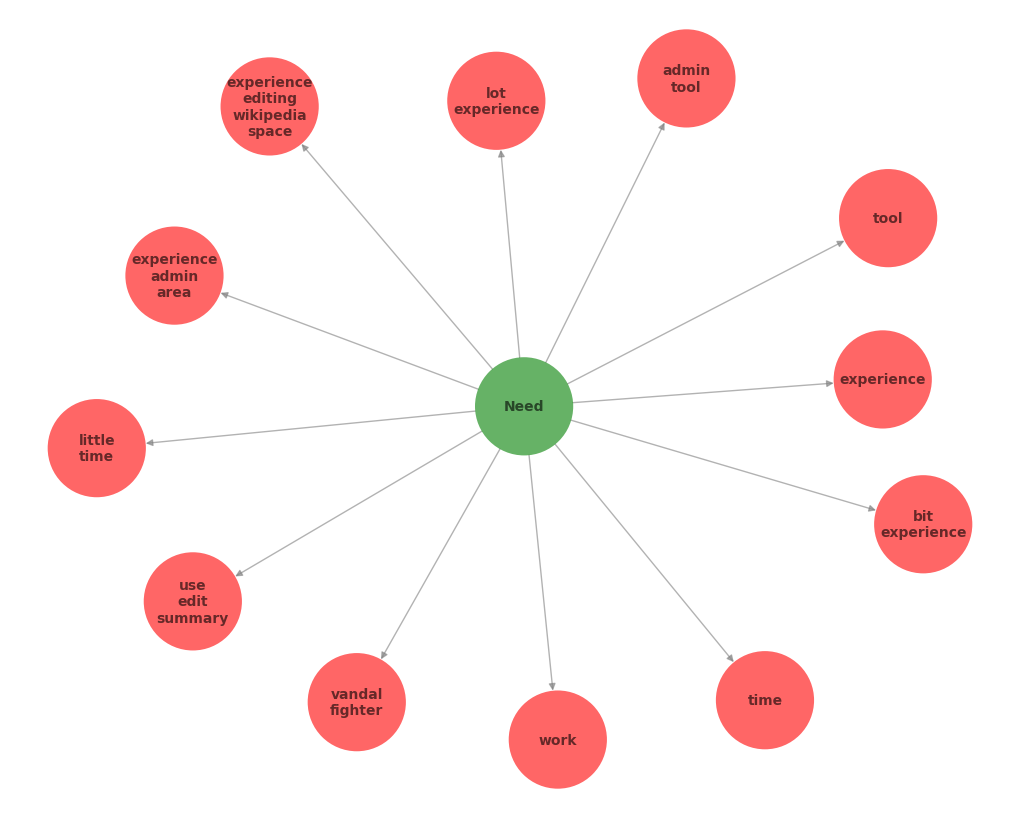

In [245]:
text_data = [
    "Need tool",
    "Need experience",
    "Need time",
    "Need work",
    "Need admin tool",
    "Need bit experience",
    "Need lot experience",
    "Need little time",
    "Need vandal fighter",
    "Need use edit summary",
    "Need experience admin area",
    "Need experience editing wikipedia space"
]

G = nx.DiGraph()

# Add "Need" and center
G.add_node("Need", size=3000, color='blue', font_size=20, font_color='black', font_weight='bold')

# Add other nodes and link with "Need"
for expression in text_data:
    words = expression.split()
    node_label = '\n'.join(words[1:])
    G.add_node(node_label)
    G.add_edge("Need", node_label)

pos = nx.spring_layout(G)

node_sizes = [100 if node == 'Need' else 30 for node in G.nodes]

node_colors = ['green' if node == 'Need' else 'red' for node in G.nodes]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, font_color='black', font_weight='bold',
        node_size=5000, node_color=node_colors, edge_color='gray', linewidths=0, alpha=0.6)
#plt.savefig("need.png", format="png")
plt.show()

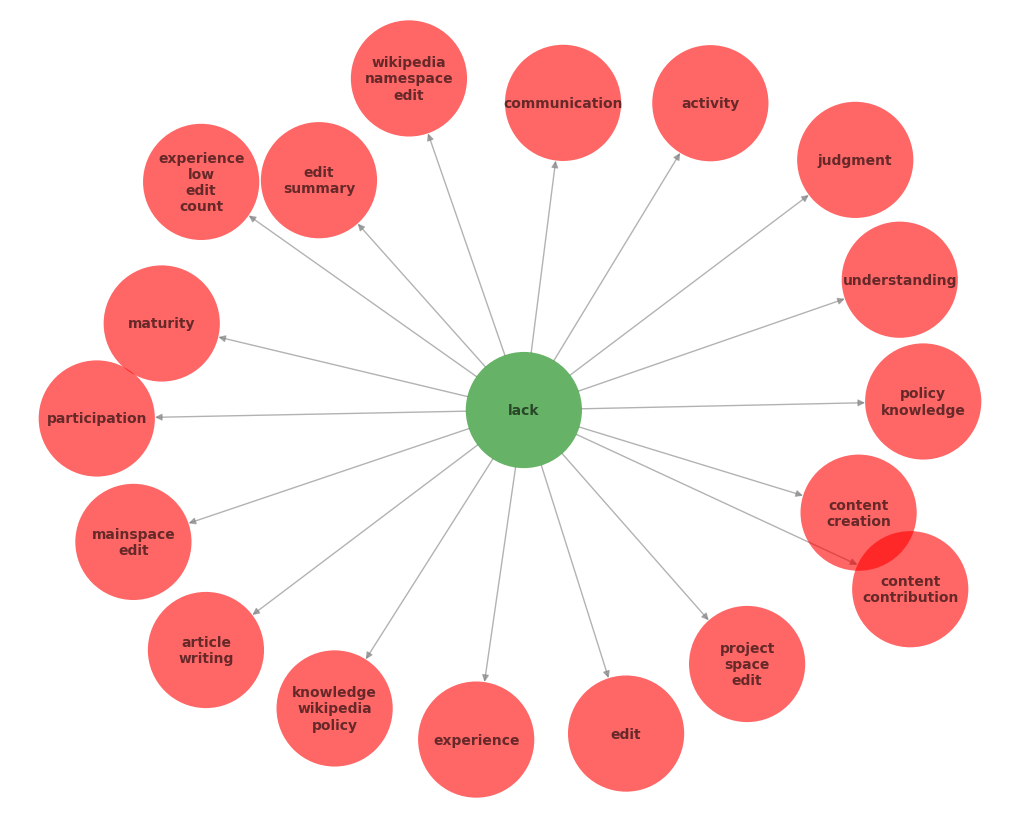

In [256]:
text_data = [
    "lack experience",
    "lack edit",
    "lack understanding",
    "lack maturity",
    "lack judgment",
    "lack activity",
    "lack participation",
    "lack communication",
    "lack edit summary",
    "lack policy knowledge",
    "lack content creation",
    "lack content contribution",
    "lack mainspace edit",
    "lack article writing",
    "lack wikipedia namespace edit",
    "lack knowledge wikipedia policy",
    "lack project space edit",
    "lack experience low edit count"
]

G = nx.DiGraph()

# Add "lack" and center
G.add_node("lack", size=3000, color='blue', font_size=20, font_color='black', font_weight='bold')

# Add other nodes and link with "Need"
for expression in text_data:
    words = expression.split()
    node_label = '\n'.join(words[1:])
    G.add_node(node_label)
    G.add_edge("lack", node_label)

pos = nx.spring_layout(G)

node_sizes = [100 if node == 'lack' else 30 for node in G.nodes]

node_colors = ['green' if node == 'lack' else 'red' for node in G.nodes]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, font_color='black', font_weight='bold',
        node_size=7000, node_color=node_colors, edge_color='gray', linewidths=0, alpha=0.6)
#plt.savefig("lack.png", format="png")
plt.show()

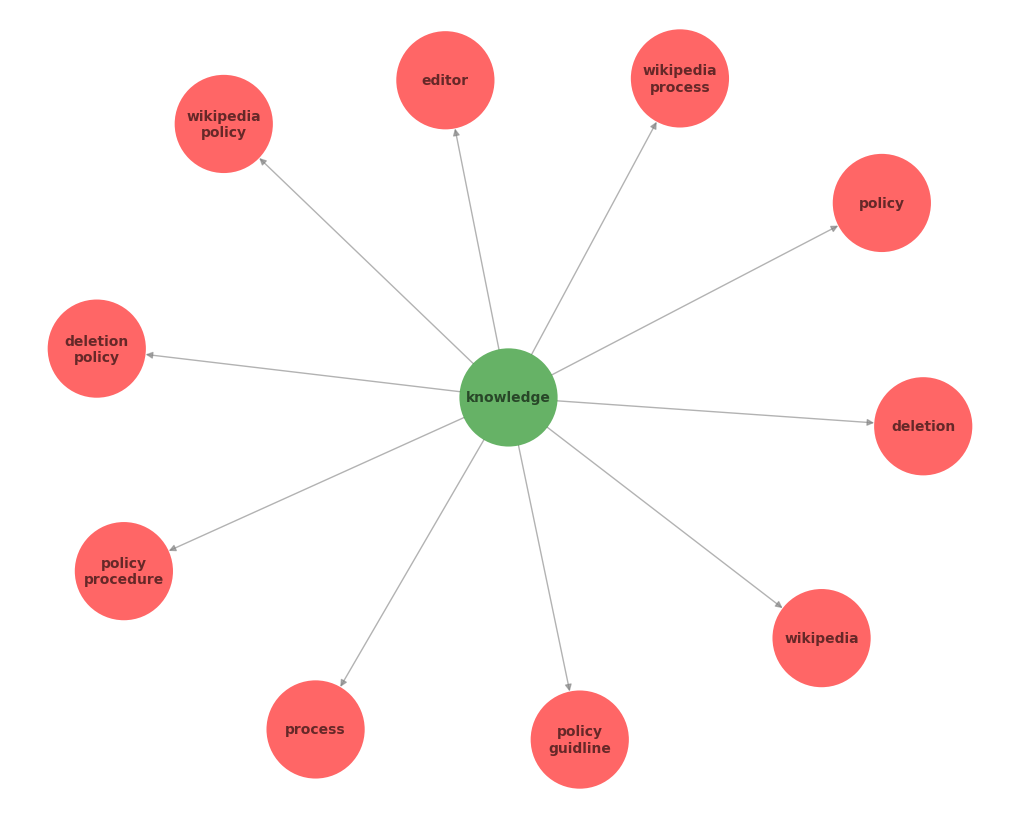

In [255]:
text_data = [
    "knowledge policy",
    "knowledge wikipedia",
    "knowledge editor",
    "knowledge deletion",
    "knowledge process",
    "knowledge wikipedia policy",
    "knowledge policy guidline",
    "knowledge policy procedure",
    "knowledge deletion policy",
    "knowledge wikipedia process"
]

G = nx.DiGraph()

# Add "knowledge" and center
G.add_node("knowledge", size=3000, color='blue', font_size=20, font_color='black', font_weight='bold')

# Add other nodes and link with "knowledge"
for expression in text_data:
    words = expression.split()
    node_label = '\n'.join(words[1:])
    G.add_node(node_label)
    G.add_edge("knowledge", node_label)

pos = nx.spring_layout(G)

node_sizes = [100 if node == 'knowledge' else 30 for node in G.nodes]

node_colors = ['green' if node == 'knowledge' else 'red' for node in G.nodes]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, font_color='black', font_weight='bold',
        node_size=5000, node_color=node_colors, edge_color='gray', linewidths=0, alpha=0.6)
#plt.savefig("knowledge.png", format="png")
plt.show()

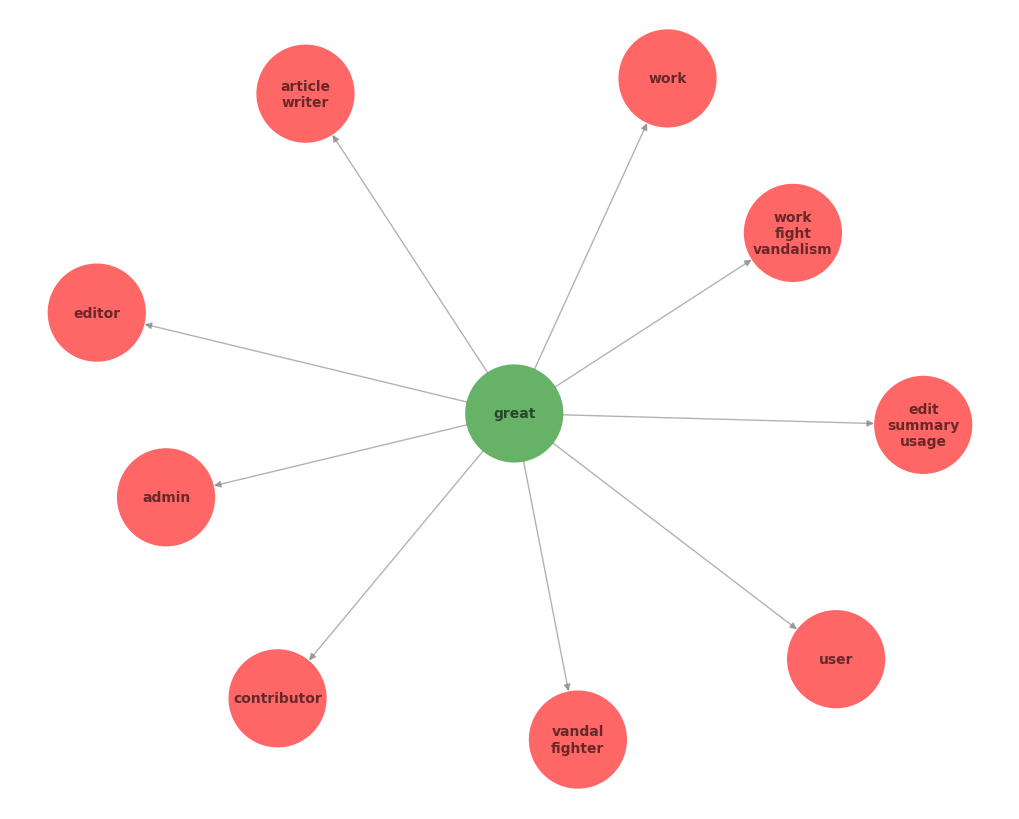

In [248]:
text_data = [
    "great admin",
    "great editor",
    "great user",
    "great work",
    "great contributor",
    "great vandal fighter",
    "great article writer",
    "great edit summary usage",
    "great work fight vandalism"
]


G = nx.DiGraph()

# Add "great" and center
G.add_node("great", size=3000, color='blue', font_size=20, font_color='black', font_weight='bold')

# Add other nodes and link with "great"
for expression in text_data:
    words = expression.split()
    node_label = '\n'.join(words[1:])
    G.add_node(node_label)
    G.add_edge("great", node_label)

pos = nx.spring_layout(G)

node_sizes = [100 if node == 'great' else 30 for node in G.nodes]

node_colors = ['green' if node == 'great' else 'red' for node in G.nodes]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, font_color='black', font_weight='bold',
        node_size=5000, node_color=node_colors, edge_color='gray', linewidths=0, alpha=0.6)
#plt.savefig("great.png", format="png")
plt.show()

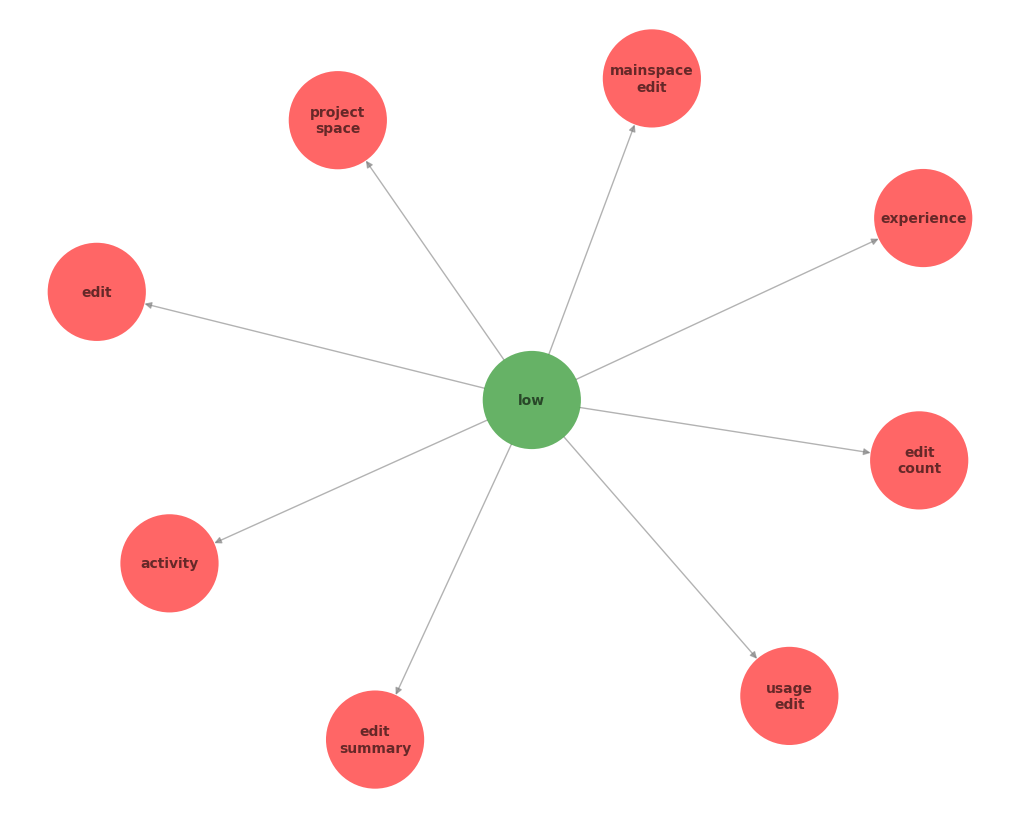

In [249]:
text_data = [
    "low edit",
    "low activity",
    "low experience",
    "low edit count",
    "low edit summary",
    "low mainspace edit",
    "low project space",
    "low usage edit"
]


G = nx.DiGraph()

# Add "great" and center
G.add_node("low", size=3000, color='blue', font_size=20, font_color='black', font_weight='bold')

# Add other nodes and link with "great"
for expression in text_data:
    words = expression.split()
    node_label = '\n'.join(words[1:])
    G.add_node(node_label)
    G.add_edge("low", node_label)

pos = nx.spring_layout(G)

node_sizes = [100 if node == 'low' else 30 for node in G.nodes]

node_colors = ['green' if node == 'low' else 'red' for node in G.nodes]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, font_color='black', font_weight='bold',
        node_size=5000, node_color=node_colors, edge_color='gray', linewidths=0, alpha=0.6)
#plt.savefig("low.png", format="png")
plt.show()